In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from IPython.display import Image
#from sklearn.model_selection import KFold
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score

import missingno as msno


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family = 'D2coding')
mpl.rc('axes', unicode_minus=False)

sns.set(font="malgun gothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc('figure', figsize=( 10, 8))

warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve, classification_report

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer


# 평가지표 분류
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {:.4f}, 정밀도 : {:.4f}, 재현율 : {:.4f}, F1 : {:.4f}, AUC : {:.4f}'.
          format(accuracy, precision, recall, f1, roc_auc))

# 재현율과 정밀도의 시각화
def precision_recall_curve_plot(y_test, pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, Y_pred_proba)
    
    plt.figure(figsize = (10, 7))
    plt.rc('font', family = 'D2coding')
    threshold_boundary = thresholds.shape[0]
    a = thresholds[precisions[0:threshold_boundary] == recalls[0:threshold_boundary]]
    loc = np.where(thresholds == a[0])[0][0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    plt.scatter(thresholds[loc], precisions[loc], c = 'black', s = 60)
    plt.text(0.02 + thresholds[loc], precisions[loc], '임계값 : {:.3f}'.format(thresholds[loc]), size = 15)
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2), size = 15)
    plt.xlabel('Threshold value', size = 15); plt.ylabel('Precision and Recall value', size = 15)
    plt.legend()
    plt.rc('legend', fontsize = 15)
    plt.rc('ytick', labelsize = 15)
    plt.show()
    

# 임계값 조정 함수
def get_clf_eval_thres(y_test, pred_po, threshold, f1_show=False, auc_show=False):
    eval_df = pd.DataFrame()
    
    for thres in threshold:
        # threshold에 따른 예측 분류 값
        binarizer = Binarizer(threshold = thres)
        binarizer.fit(pred_po)
        thres_pred = binarizer.transform(pred_po)
        
        # 평가지표  
        accuracy = accuracy_score(y_test, thres_pred)
        precision = precision_score(y_test, thres_pred)
        recall = recall_score(y_test, thres_pred)
        f1 = f1_score(y_test, thres_pred)
        auc = roc_auc_score(y_test, pred_po)
        
        # 데이터 프레임 형태
        eval_lst = np.array([accuracy, precision, recall, f1, auc]).reshape(-1,1)
        temp = pd.DataFrame(eval_lst, columns=[thres], 
                            index = ["정확도", "정밀도", "재현율", "F1스코어", "AUC"])
        eval_df = pd.concat([eval_df,temp], axis=1)
        
    eval_df.columns.names = ["임계값"]
    
    if f1_show == False:
        eval_df.drop("F1스코어", axis=0, inplace=True)
        
    if auc_show == False:
        eval_df.drop("AUC", axis=0, inplace=True)
        
    return round(eval_df, 4)

In [4]:
data = pd.read_csv('C:/k_digital/source/data/open/train.csv')
test = pd.read_csv('C:/k_digital/source/data/open/test.csv')

In [5]:
data['FOPTIMETHGLY'].value_counts()

0.0     1954
1.0     1834
2.0       90
3.0        8
13.0       1
7.0        1
5.0        1
10.0       1
Name: FOPTIMETHGLY, dtype: int64

# 데이터 탐색 및 전처리(EDA)

## 데이터 유형 확인

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  int64  
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  int64  
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CD                   12701 non-null  float64
 13  CO                   14095 non-null  int64  
 14  CR                   14095 non-null  int64  
 15  CU                   14095 non-null 

## profiling

In [7]:
#!pip install pandas_profiling

import pandas_profiling
profile_report = pandas_profiling.ProfileReport(data)
profile_report

## 결측치 확인
- U를 2개의 그룹으로 합친 다음에 결측치를 0으로 대체 
- 결측치 0으로 바꾸기

In [8]:
# 비율로 확인 
missing_value = data.isna().sum()
total = data.shape[0]
ratio = round(missing_value/total,2)
print(round(missing_value/total,2))
ratio.sort_values(ascending=False).head(17).index
#  ['U4', 'U6', 'U14', 'U20', 'U50', 'U100', 'U75', 'U25', 'V100', 'FH2O',
#        'FOXID', 'FUEL', 'FOPTIMETHGLY', 'FSO4', 'FTBN', 'SOOTPERCENTAGE',
#        'FNOX'] --> 결측치 70% 이상 

ID                     0.00
COMPONENT_ARBITRARY    0.00
ANONYMOUS_1            0.00
YEAR                   0.00
SAMPLE_TRANSFER_DAY    0.00
ANONYMOUS_2            0.00
AG                     0.00
AL                     0.00
B                      0.00
BA                     0.00
BE                     0.00
CA                     0.00
CD                     0.10
CO                     0.00
CR                     0.00
CU                     0.00
FH2O                   0.72
FNOX                   0.72
FOPTIMETHGLY           0.72
FOXID                  0.72
FSO4                   0.72
FTBN                   0.72
FE                     0.00
FUEL                   0.72
H2O                    0.00
K                      0.16
LI                     0.00
MG                     0.00
MN                     0.00
MO                     0.00
NA                     0.00
NI                     0.00
P                      0.00
PB                     0.00
PQINDEX                0.00
S                   

Index(['U4', 'U6', 'U14', 'U20', 'U50', 'U100', 'U75', 'U25', 'V100', 'FH2O',
       'FOXID', 'FUEL', 'FOPTIMETHGLY', 'FSO4', 'FTBN', 'SOOTPERCENTAGE',
       'FNOX'],
      dtype='object')

<Figure size 1000x1500 with 0 Axes>

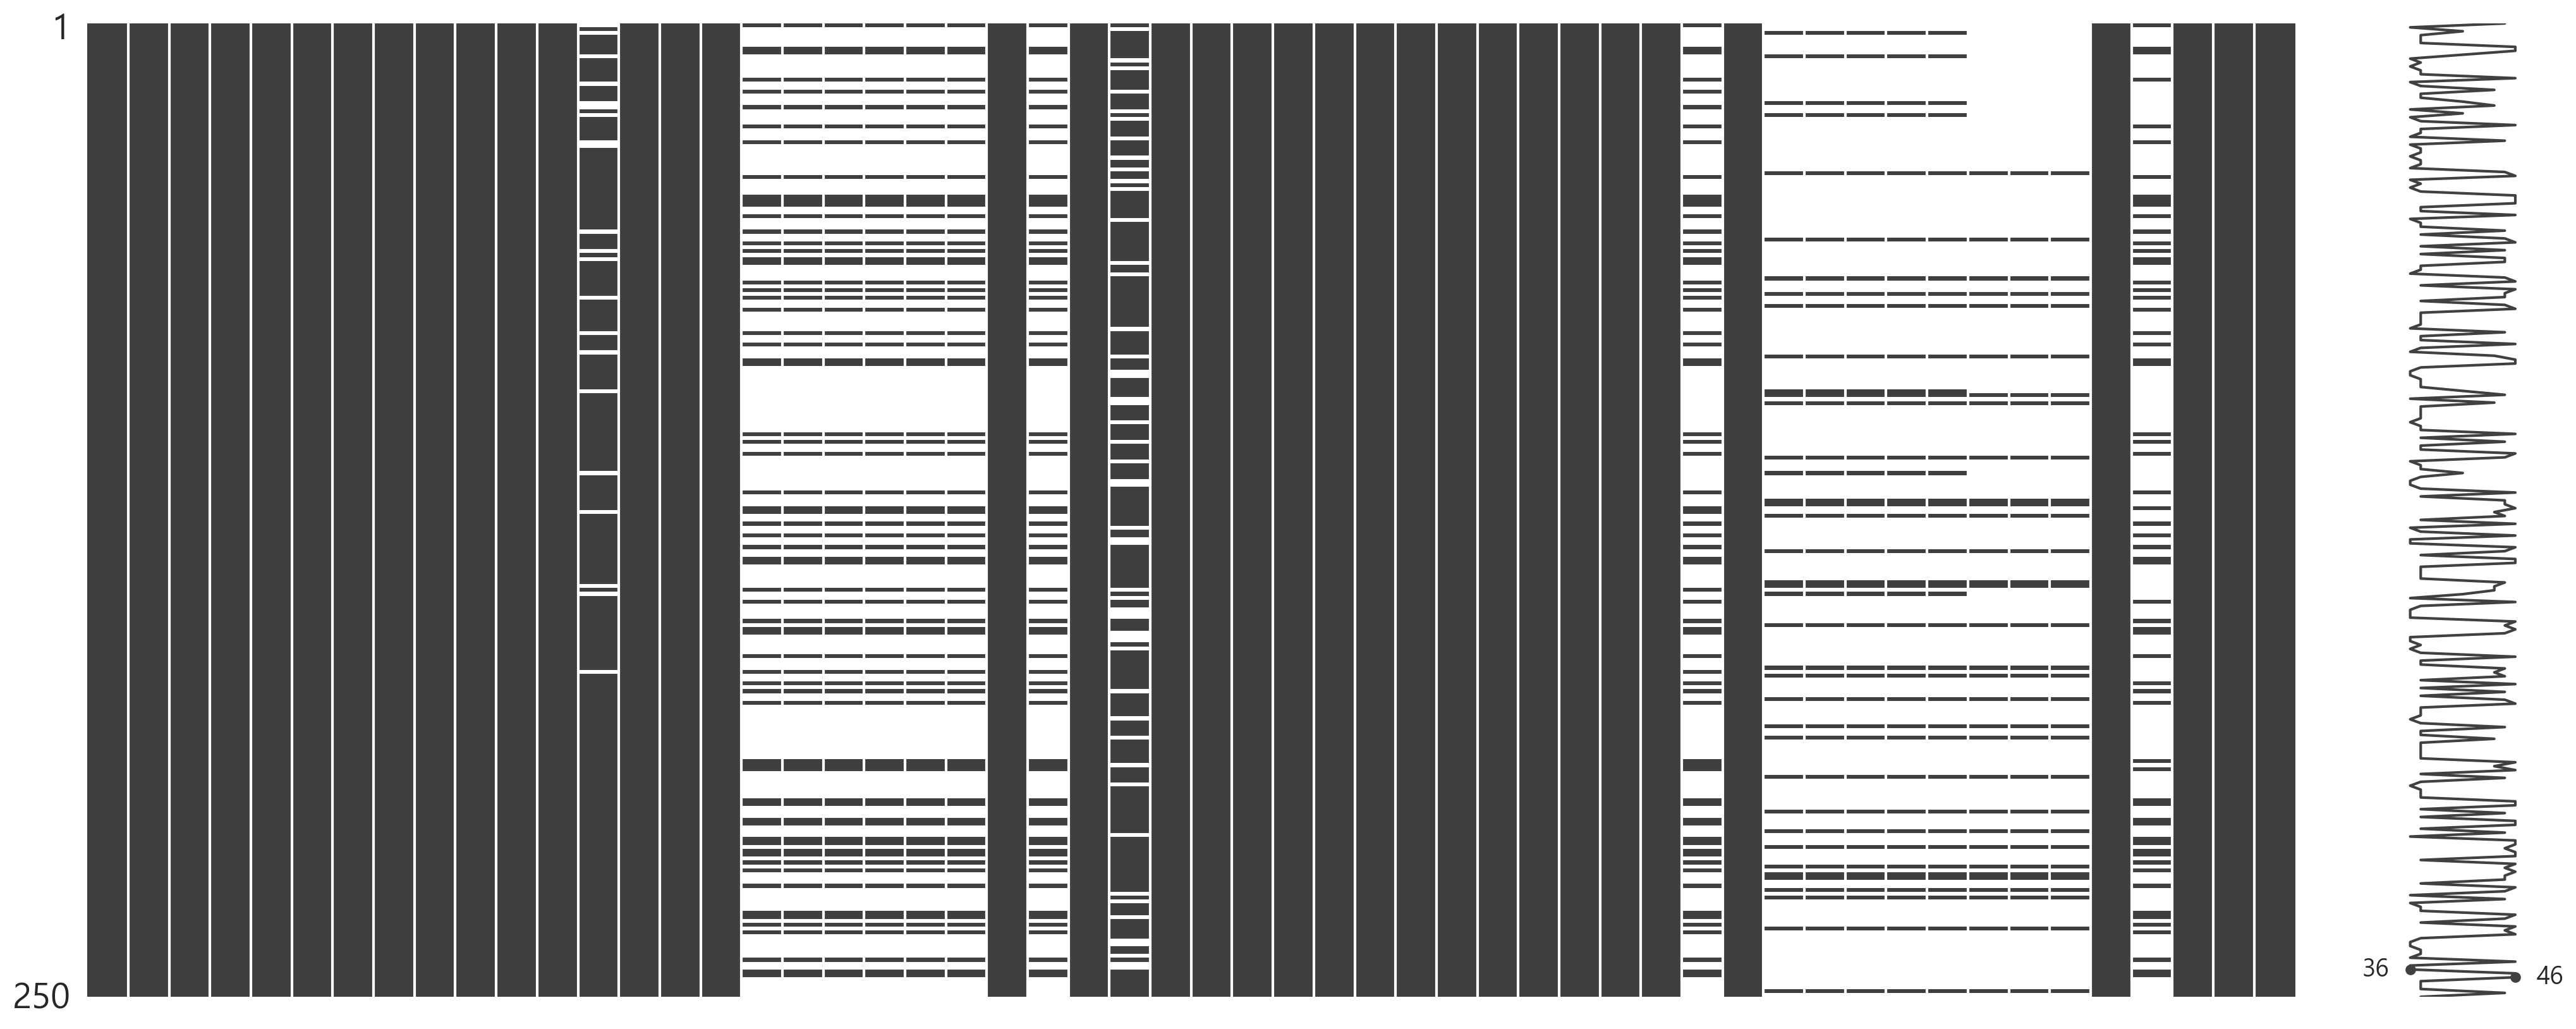

In [9]:
# 결측치 시각화 
plt.figure(figsize=(10,15))
msno.matrix(data.sample(250))
plt.show()

<AxesSubplot:>

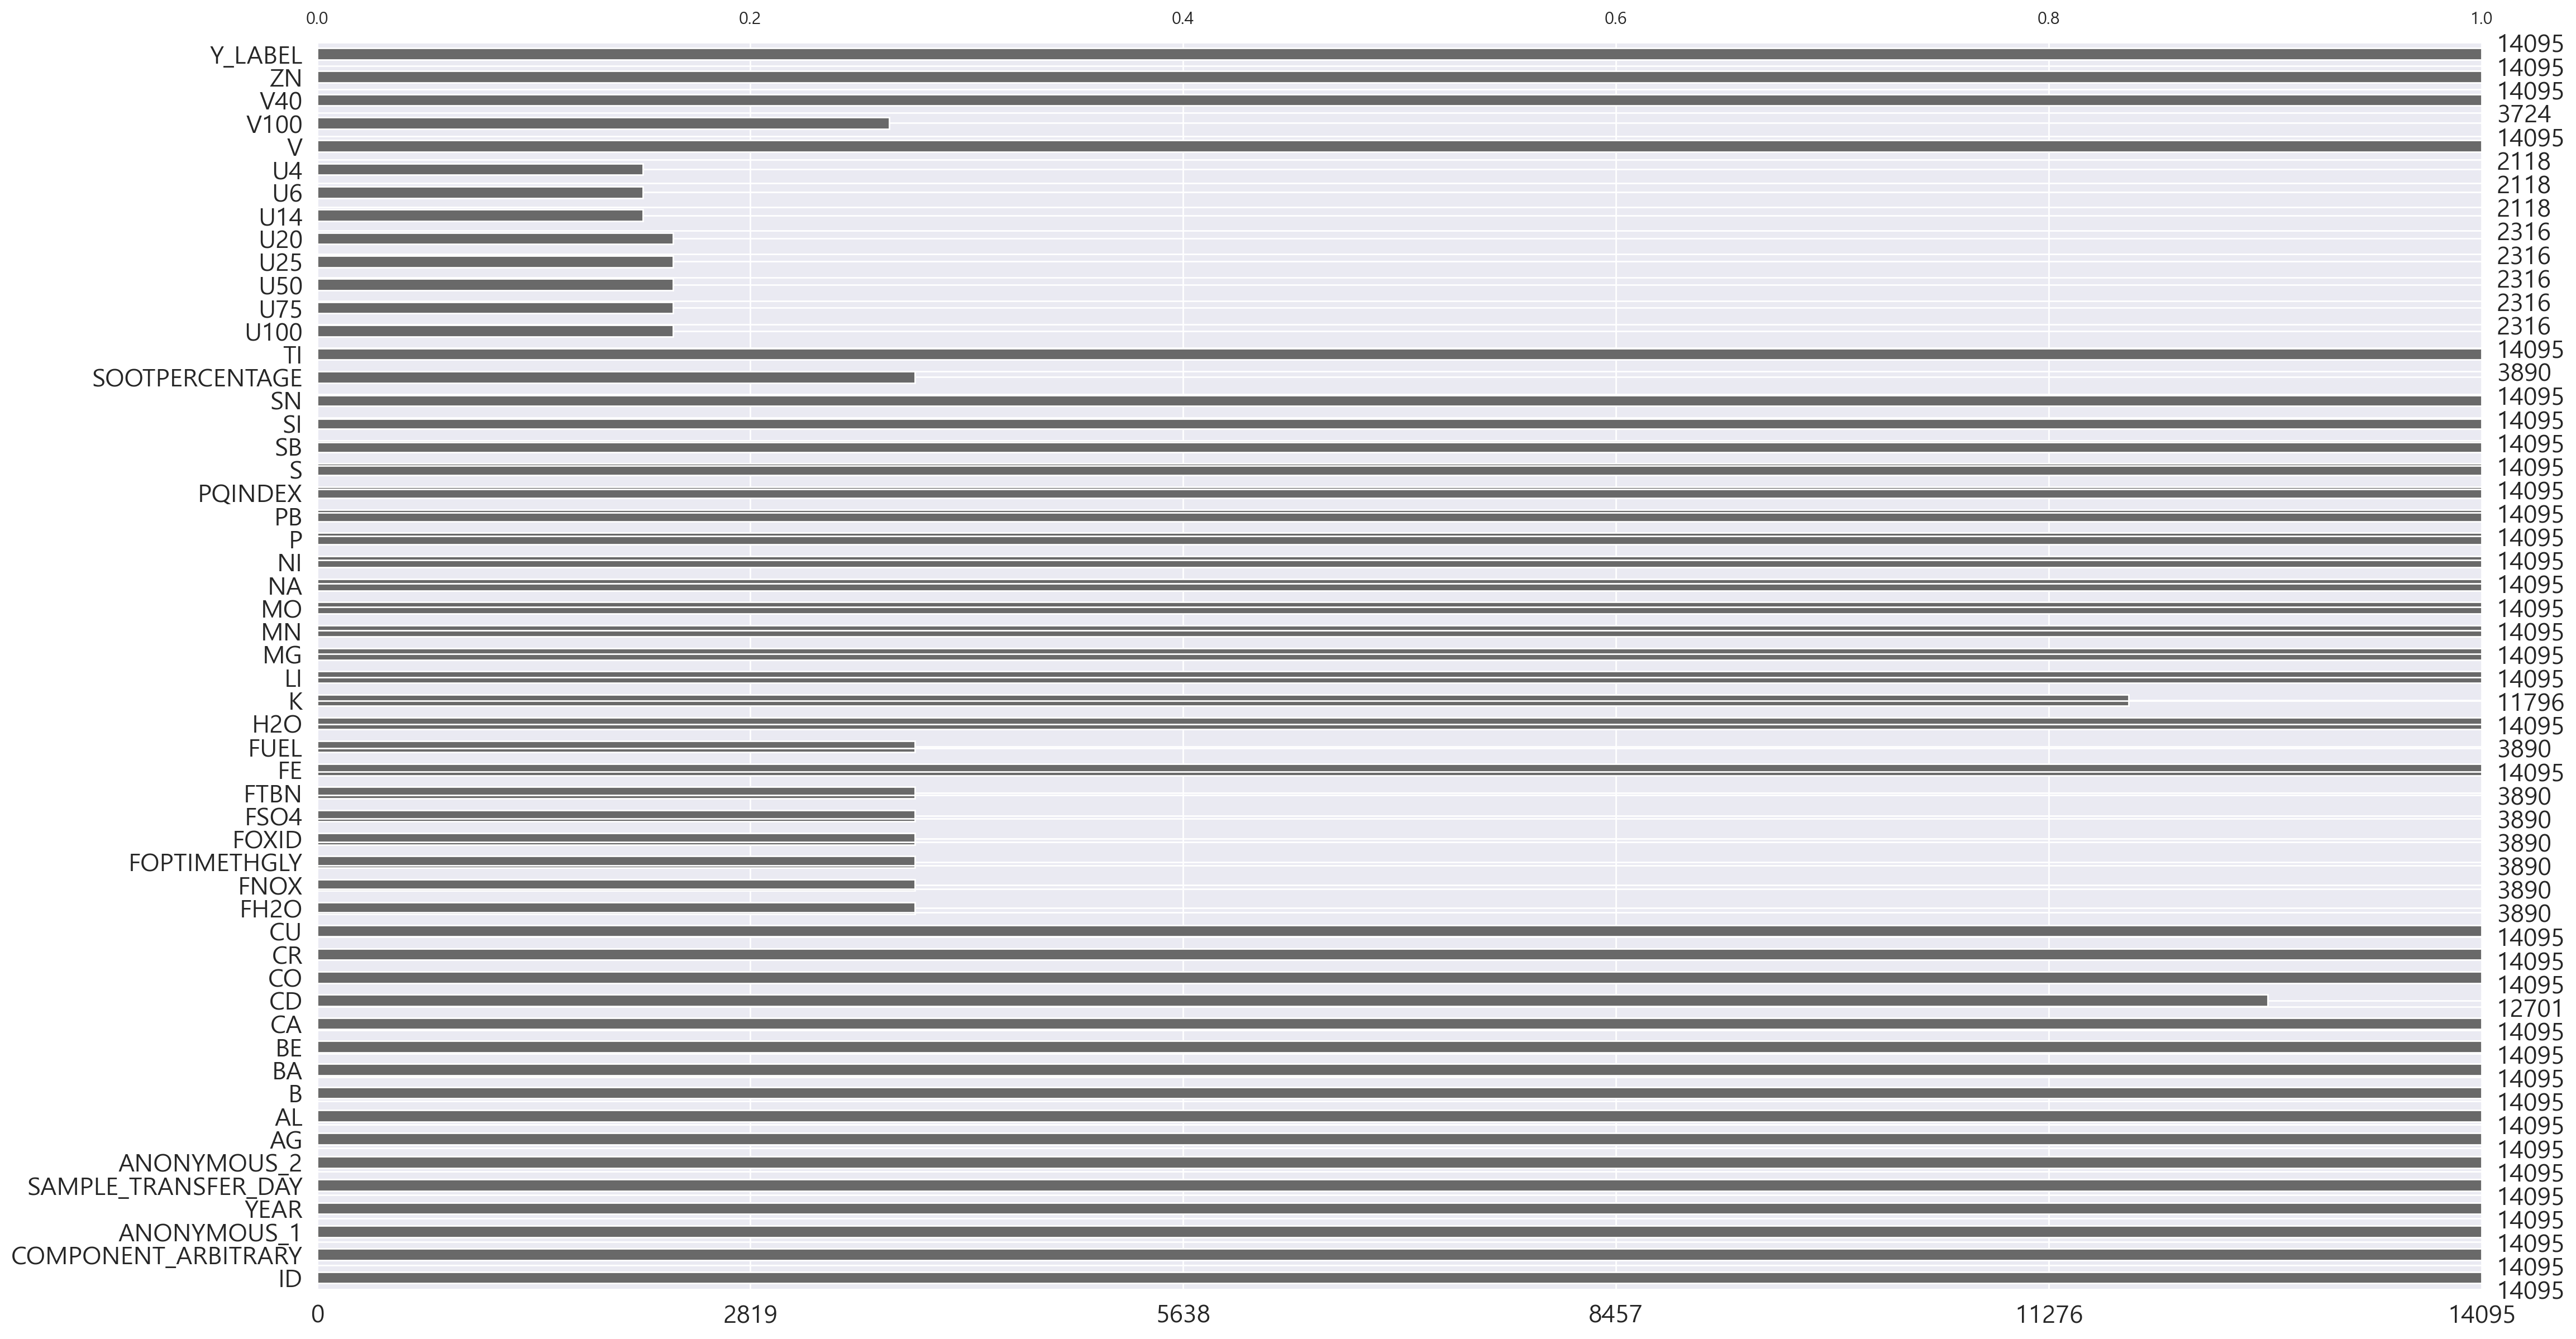

In [10]:
# bar
msno.bar(data)

<AxesSubplot:>

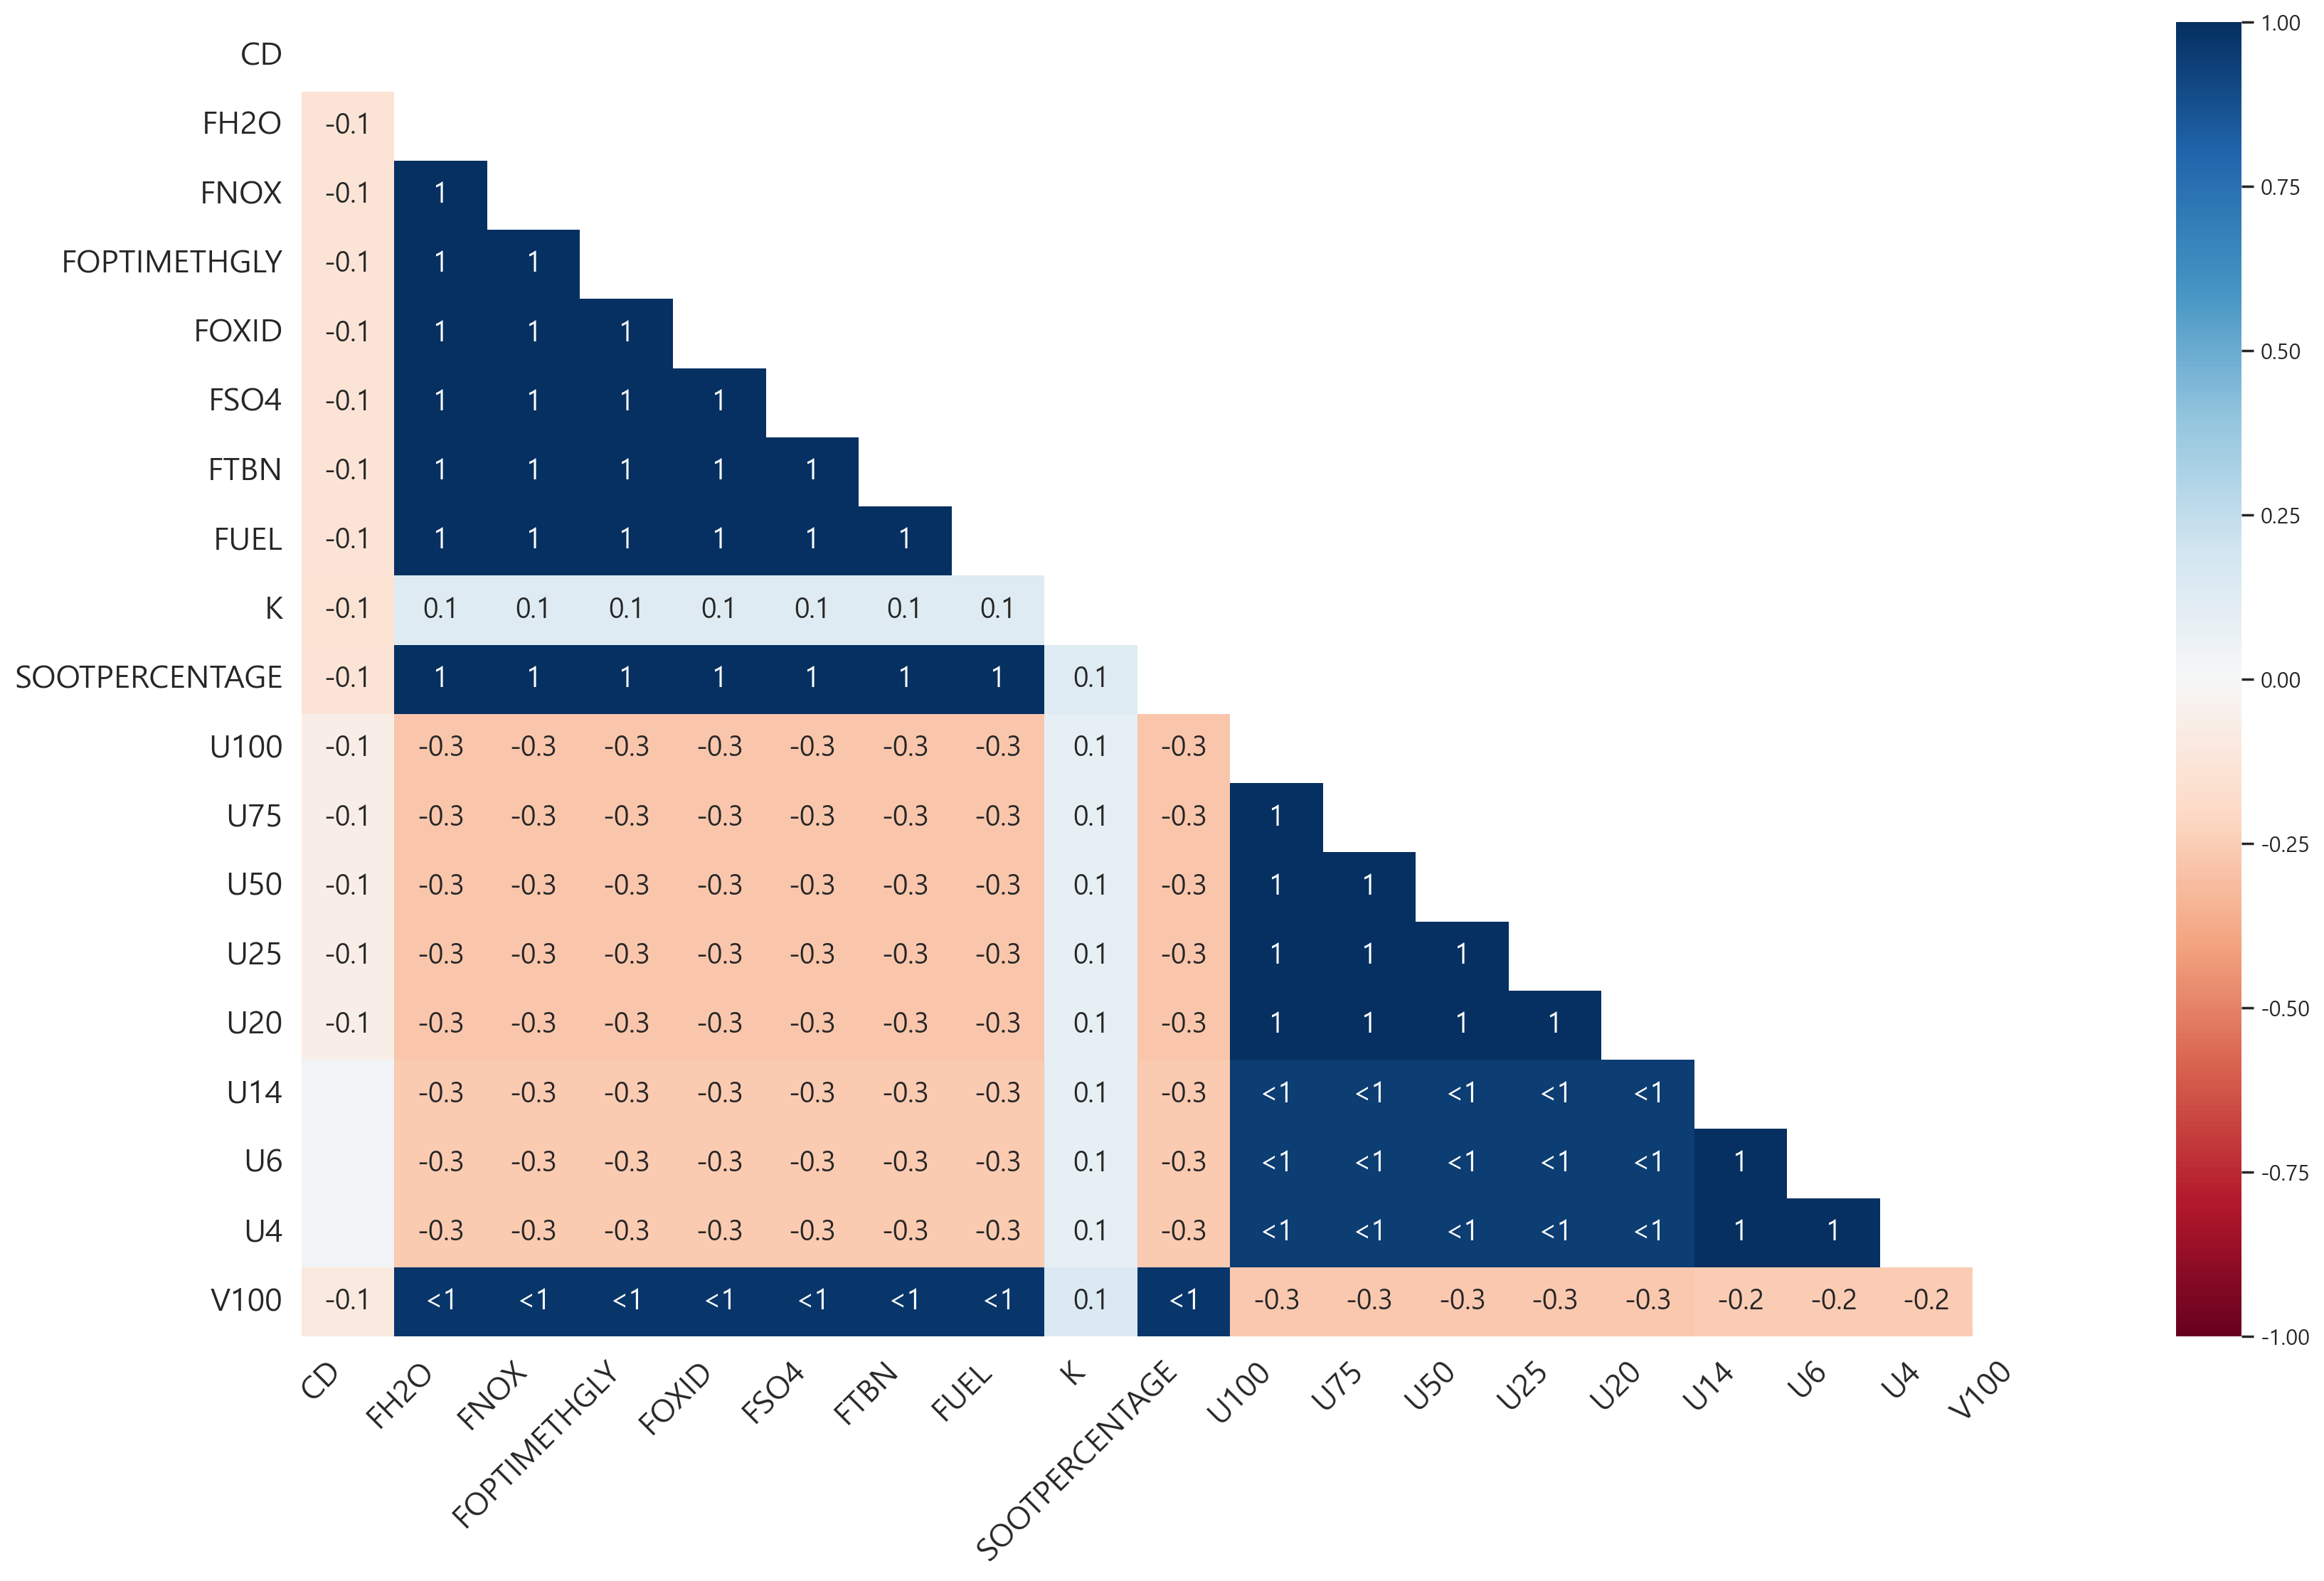

In [11]:
#한 변수의 유무가 다른 변수의 존재에 얼마나 강하게 영향을 미치는지입니다.
# 결측치가 너무 많아서 "1"로 뜬 것 같다. 
msno.heatmap(data)

## 결측치 수정 및 대체 

In [12]:
data = data[['ANONYMOUS_1','AL','CA','FE','B','P','S','PQINDEX','V40','MO','ZN','FTBN',
     'SI','CU','ANONYMOUS_2','SAMPLE_TRANSFER_DAY','MG','NA','CR','BA','U4','TI','PB','NI','SN',
     'K','MN','U20','COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL']]

# 결측치 0 으로 채우기
feature = ['K','U4']
for i in feature:
    data[i].fillna(0, inplace=True)  
    

    
FTBN = pd.DataFrame(data['FTBN'])
FTBN
# 결측값을 예측을 통해 채워넣음 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=100)
FTBN_imputed = imputer.fit_transform(FTBN)

# describe()를 하기위해 dataframe으로 바꿔줌 
FTBN_imputed = pd.DataFrame(FTBN_imputed)
data['FTBN'] = FTBN_imputed

# U20에 있는 결측치 0으로 처리
data['U20'] = data['U20'].fillna(0)


In [13]:
data

,ANONYMOUS_1,AL,CA,FE,B,P,S,PQINDEX,V40,MO,...,TI,PB,NI,SN,K,MN,U20,COMPONENT_ARBITRARY,YEAR,Y_LABEL
0,1486,3,3059,888,93,1951,21370,8504,154.0,1,...,5,0,6,2,27.0,16,0.0,COMPONENT3,2011,0
1,1350,2,2978,2,19,572,1117,19,44.0,0,...,0,2,0,0,0.0,0,4.0,COMPONENT2,2021,0
2,2415,110,17,4,1,328,1334,17,72.6,0,...,0,0,0,1,0.0,0,3.0,COMPONENT2,2015,1
3,7389,8,1960,37,3,906,21774,44,133.3,0,...,0,1,0,1,0.0,1,0.0,COMPONENT3,2010,0
4,3954,1,71,71,157,309,18470,217,133.1,0,...,0,0,0,0,0.0,0,0.0,COMPONENT3,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,1616,2,6,23,201,477,22000,35,135.4,0,...,0,0,0,0,1.0,0,0.0,COMPONENT3,2014,0
14091,2784,3,2945,12,85,1163,5494,9,117.5,224,...,0,1,0,0,4.0,0,0.0,COMPONENT1,2013,0
14092,1788,6,13,415,0,1175,9640,645,54.0,10,...,0,1,1,0,0.0,7,0.0,COMPONENT3,2008,0
14093,2498,2,2244,19,4,441,1313,11,44.3,1,...,0,1,0,0,0.0,0,8.0,COMPONENT2,2009,0


# 데이터 스케일링

In [14]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']

In [15]:
data2 = data.drop(['COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL'], axis = 1)
data2.columns

Index(['ANONYMOUS_1', 'AL', 'CA', 'FE', 'B', 'P', 'S', 'PQINDEX', 'V40', 'MO',
       'ZN', 'FTBN', 'SI', 'CU', 'ANONYMOUS_2', 'SAMPLE_TRANSFER_DAY', 'MG',
       'NA', 'CR', 'BA', 'U4', 'TI', 'PB', 'NI', 'SN', 'K', 'MN', 'U20'],
      dtype='object')

In [16]:
for i in range(len(data2.columns)):
    data2.iloc[:, i] = np.log1p(data2.iloc[:, i])

In [17]:
# data = pd.get_dummies(data, columns = categorical_features)

In [18]:
# data.columns

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in categorical_features:    
    data[col] = le.fit_transform(data[col])

In [20]:
onehot = data[['COMPONENT_ARBITRARY','YEAR']]
scaled = pd.concat([onehot, data2], axis = 1)
scaled

,COMPONENT_ARBITRARY,YEAR,ANONYMOUS_1,AL,CA,FE,B,P,S,PQINDEX,...,CR,BA,U4,TI,PB,NI,SN,K,MN,U20
0,2,4,7.304516,1.386294,8.026170,6.790097,4.543295,7.576610,9.969790,9.048410,...,2.639057,0.000000,0.000000,1.791759,0.000000,1.945910,1.098612,3.332205,2.833213,0.000000
1,1,14,7.208600,1.098612,7.999343,1.098612,2.995732,6.350886,7.019297,2.995732,...,0.000000,0.000000,7.282761,0.000000,1.098612,0.000000,0.000000,0.000000,0.000000,1.609438
2,1,8,7.789869,4.709530,2.890372,1.609438,0.693147,5.796058,7.196687,2.890372,...,0.693147,0.693147,10.623325,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,1.386294
3,2,3,8.907883,2.197225,7.581210,3.637586,1.386294,6.810142,9.988518,3.806662,...,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.693147,0.000000,0.693147,0.000000
4,2,8,8.282736,0.693147,4.276666,4.276666,5.062595,5.736572,9.823957,5.384495,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,2,7,7.388328,1.098612,1.945910,3.178054,5.308268,6.169611,9.998843,3.583519,...,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000
14091,0,6,7.932003,1.386294,7.988204,2.564949,4.454347,7.059618,8.611594,2.302585,...,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,1.609438,0.000000,0.000000
14092,2,1,7.489412,1.945910,2.639057,6.030685,0.000000,7.069874,9.173780,6.470800,...,1.609438,0.693147,0.000000,0.000000,0.693147,0.693147,0.000000,0.000000,2.079442,0.000000
14093,1,2,7.823646,1.098612,7.716461,2.995732,1.609438,6.091310,7.180831,2.484907,...,0.000000,0.000000,9.846441,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,2.197225


In [21]:
# scaled.drop(['COMPONENT_ARBITRARY_COMPONENT1',
#        'COMPONENT_ARBITRARY_COMPONENT2', 'COMPONENT_ARBITRARY_COMPONENT3',
#        'COMPONENT_ARBITRARY_COMPONENT4', 'YEAR_2007', 'YEAR_2008', 'YEAR_2009',
#        'YEAR_2010', 'YEAR_2011', 'YEAR_2012', 'YEAR_2013', 'YEAR_2014',
#        'YEAR_2015', 'YEAR_2016', 'YEAR_2017', 'YEAR_2018', 'YEAR_2019',
#        'YEAR_2020', 'YEAR_2021', 'YEAR_2022'], axis = 1).hist(bins=80, figsize=(20,20))
# plt.show()

# train, test 세트 분리

In [22]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(scaled, data['Y_LABEL'], test_size = 0.2, random_state = 2022, stratify = data['Y_LABEL'])

# 샘플링기법 적용

## 언더샘플링

In [23]:
from imblearn.under_sampling import NearMiss

nearmiss=NearMiss()
under_X,under_y = nearmiss.fit_resample(X_train, y_train)
print("NearMiss 적용 전 학습용 피처/레이블 데이터 세트 : ", X_train.shape, y_train.shape)
print('NearMiss 적용 후 학습용 피처/레이블 데이터 세트 :', under_X.shape, under_y.shape)
print('NearMiss 적용 후 값의 분포 :\n',pd.Series(under_y).value_counts())

NearMiss 적용 전 학습용 피처/레이블 데이터 세트 :  (11276, 30) (11276,)
NearMiss 적용 후 학습용 피처/레이블 데이터 세트 : (1924, 30) (1924,)
NearMiss 적용 후 값의 분포 :
 0    962
1    962
Name: Y_LABEL, dtype: int64


## 오버샘플링

In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 값의 분포 :\n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (11276, 30) (11276,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (20628, 30) (20628,)
SMOTE 적용 후 값의 분포 :
 0    10314
1    10314
Name: Y_LABEL, dtype: int64


## 언더 & 오버 샘플링

In [25]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_train_smt, y_train_smt = smoteto.fit_resample(X_train, y_train)
print("SMOTETomek 적용 전 학습용 피처/레이블 데이터 세트 : ", X_train.shape, y_train.shape)
print('SMOTETomek 적용 후 학습용 피처/레이블 데이터 세트 :', X_train_smt.shape, y_train_smt.shape)
print('SMOTETomek 적용 후 값의 분포 :\n',pd.Series(y_train_smt).value_counts())

SMOTETomek 적용 전 학습용 피처/레이블 데이터 세트 :  (11276, 30) (11276,)
SMOTETomek 적용 후 학습용 피처/레이블 데이터 세트 : (20626, 30) (20626,)
SMOTETomek 적용 후 값의 분포 :
 1    10314
0    10312
Name: Y_LABEL, dtype: int64


# 알고리즘 적용

In [ ]:
# 혼돈 행렬 시각화
def confusion(y_test, Y_preds):
    cm = confusion_matrix(y_test, Y_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot = True, annot_kws = {'size':20}, fmt = '0.0f', cmap='Blues')
    plt.xlabel('Predicted', size = 20)
    plt.ylabel('Actual', size = 20)
    plt.text(0.45, 0.4, 'TN', color = 'w', fontsize = 20)
    plt.text(1.45, 0.4, 'FP', color = 'black', fontsize = 20)
    plt.text(0.45, 1.4, 'FN', color = 'black', fontsize = 20)
    plt.text(1.45, 1.4, 'TP', color = 'black', fontsize = 20)
    plt.show()
    
def roc_auc_graph(y_test, Y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, Y_pred_proba)

    plt.figure(figsize=(10, 8))
    plt.plot([0,1], [0,1], "r--")
    plt.plot(fpr, tpr, label='XGBoost', color = '#175617')
    plt.xlabel('False Positive Rate', size = 15)
    plt.ylabel('True Positive Rate', size = 15)
    plt.title('XGBoost ROC curve', size = 15)
    plt.text(0.3, 0.45, 'AUC 면적 = {}'.format(round(roc_auc_score(y_test, Y_pred_proba), 4)), size = 20)
    plt.show()
    
#feature 중요도도 그려볼 수 있다. 
def importance(model):
    from xgboost import plot_importance
    from lightgbm import plot_importance
    import matplotlib.pyplot as plt
    %matplotlib inline

    fig, ax = plt.subplots(figsize=(12, 15))

    # 사이킷런 래퍼 클래스를 입력해도 무방. 
    plot_importance(model, ax=ax)
    plt.rc('font', size=20)        # 기본 폰트 크기
    plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
    plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
    plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
    plt.rc('legend', fontsize = 30)
    plt.show()
    


In [ ]:
def Running(model, y_test, Y_preds, Y_pred_proba):
    return [confusion(y_test, Y_preds), precision_recall_curve_plot(y_test, Y_pred_proba), 
                     roc_auc_graph(y_test, Y_pred_proba), importance(model)]

## 원본데이터 & hyperOpt & XGBoost

In [ ]:
from xgboost import XGBClassifier
from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로 , min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 갑승로 검색
xgb_search_space = {'max_depth' : hp.quniform('max_depth', 100, 160, 1),
                    'subsample' : hp.uniform('subsample', 0.7, 1),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)
                   }

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold



# fmim()에서 호출 시 search_space 값으로 NGBClassifier 교차 검증 학습 후 -1 * roc_auc 평균 값을 반환.
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators = 300,
                            max_depth = int(search_space['max_depth']),
                            subsample = search_space['subsample'],
                            learning_rate = search_space['learning_rate'],
                            objective = 'binary:logistic', n_jobs = -1
                           )
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold 방식 적용
    skf = StratifiedKFold(n_splits=3, shuffle = True)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in skf.split(X_train, y_train):
        #kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 LGBMClassifier 학습 수행
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds = 30, eval_metric = 'auc',
                    eval_set = [(X_tr, y_tr), (X_val, y_val)])
        
        # 1로 예측환 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값을 담음
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)

    # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되, 
    # hyperOpt는 목적함수의 최솟값을 위한 입력값을 반환하므로 -1을 곱한 뒤 반환.
    return -1 * np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 호출, max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn = objective_func,
           space = xgb_search_space,
           algo = tpe.suggest,
           max_evals = 50,
            trials = trials, rstate = np.random.default_rng(seed = 30)
           )

print('best :', best)

In [ ]:
xgb = XGBClassifier(n_estimators=500,
                   max_depth = int(best['max_depth']),
                    subsample = round(best['subsample'], 5),
                    learning_rate = round(best['learning_rate'], 5),
                    objective = 'binary:logistic'
                   )

xgb.fit(X_train, y_train)

Y_preds = xgb.predict(X_test)
Y_pred_proba = xgb.predict_proba(X_test)[:, 1]

In [ ]:
get_clf_eval(y_test, Y_preds, Y_pred_proba)
print('Macro f1 socre : ', f1_score(y_test, Y_preds, average='macro'))
print('Micro f1 socre : ', f1_score(y_test, Y_preds, average='micro'))

In [ ]:
# 혼돈 행렬 시각화
cm = confusion_matrix(y_test, Y_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot = True, annot_kws = {'size':20}, fmt = '0.0f', cmap='Blues')
plt.xlabel('Predicted', size = 20)
plt.ylabel('Actual', size = 20)
plt.text(0.45, 0.4, 'TN', color = 'w', fontsize = 20)
plt.text(1.45, 0.4, 'FP', color = 'black', fontsize = 20)
plt.text(0.45, 1.4, 'FN', color = 'black', fontsize = 20)
plt.text(1.45, 1.4, 'TP', color = 'black', fontsize = 20)
plt.show()

In [ ]:
precision_recall_curve_plot(y_test, Y_pred_proba)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, Y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot([0,1], [0,1], "r--")
plt.plot(fpr, tpr, label='XGBoost', color = '#175617')
plt.xlabel('False Positive Rate', size = 15)
plt.ylabel('True Positive Rate', size = 15)
plt.title('XGBoost ROC curve', size = 15)
plt.text(0.3, 0.45, 'AUC 면적 = {}'.format(round(roc_auc_score(y_test, Y_pred_proba), 4)), size = 20)
plt.show()

In [ ]:
#feature 중요도도 그려볼 수 있다. 
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 15))

# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb, ax=ax)
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize = 30)
plt.show()

## 원본데이터 & hyprtOpt & LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로 , min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 갑승로 검색
lgbm_search_space = {'num_leaves' : hp.quniform('num_leaves', 1, 64, 1),
                     'max_depth' : hp.quniform('max_depth', 1, 160, 1),
                     'min_child_samples' : hp.quniform('min_child_samples', 30, 100, 1),
                    'subsample' : hp.uniform('subsample', 0.5, 1),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.5)
                   }

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold



# fmim()에서 호출 시 search_space 값으로 NGBClassifier 교차 검증 학습 후 -1 * roc_auc 평균 값을 반환.
def objective_func(search_space):
    lgbm_clf = LGBMClassifier(n_estimators = 500,
                            num_leaves = int(search_space['num_leaves']),
                            max_depth = int(search_space['max_depth']),
                            min_child_samples = int(search_space['min_child_samples']),
                            subsample = search_space['subsample'],
                            learning_rate = search_space['learning_rate'], n_jobs = -1)
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold 방식 적용
    skf = StratifiedKFold(n_splits=3, shuffle = True)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in skf.split(X_train, y_train):
        #kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 LGBMClassifier 학습 수행
        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds = 30, eval_metric = 'auc',
                    eval_set = [(X_tr, y_tr), (X_val, y_val)])
        
        # 1로 예측환 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값을 담음
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)

    # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되, 
    # hyperOpt는 목적함수의 최솟값을 위한 입력값을 반환하므로 -1을 곱한 뒤 반환.
    return -1 * np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 호출, max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn = objective_func,
           space = lgbm_search_space,
           algo = tpe.suggest,
           max_evals = 50,
            trials = trials, rstate = np.random.default_rng(seed = 30)
           )

print('best :', best)

In [ ]:
ngb = LGBMClassifier(n_estimators=500, num_leaves = int(best['num_leaves']),
                   max_depth = int(best['max_depth']),
                    min_child_samples = int(best['min_child_samples']),
                    subsample = round(best['subsample'], 5),
                    learning_rate = round(best['learning_rate'], 5),
                     objective = 'binary',
                     metric = 'binary_logloss'
                   )



ngb.fit(X_train, y_train)

Y_preds = ngb.predict(X_test)
Y_pred_proba = ngb.predict_proba(X_test)[:, 1]

In [ ]:
get_clf_eval(y_test, Y_preds, Y_pred_proba)
print('Macro f1 socre : ', f1_score(y_test, Y_preds, average='macro'))
print('Micro f1 socre : ', f1_score(y_test, Y_preds, average='micro'))

In [ ]:
# 혼돈 행렬 시각화
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot = True, annot_kws = {'size':20}, fmt = '0.0f', cmap='Blues')
plt.xlabel('Predicted', size = 20)
plt.ylabel('Actual', size = 20)
plt.text(0.45, 0.4, 'TN', color = 'w', fontsize = 20)
plt.text(1.45, 0.4, 'FP', color = 'black', fontsize = 20)
plt.text(0.45, 1.4, 'FN', color = 'black', fontsize = 20)
plt.text(1.45, 1.4, 'TP', color = 'black', fontsize = 20)
plt.show()

In [ ]:
precision_recall_curve_plot(y_test, Y_pred_proba)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, Y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot([0,1], [0,1], "r--")
plt.plot(fpr, tpr, label='LightGBM', color = '#175617')
plt.xlabel('False Positive Rate', size = 15)
plt.ylabel('True Positive Rate', size = 15)
plt.title('LightGBM ROC curve', size = 15)
plt.text(0.3, 0.45, 'AUC 면적 = {}'.format(round(roc_auc_score(y_test, Y_pred_proba), 4)), size = 20)
plt.show()

In [ ]:
#feature 중요도도 그려볼 수 있다. 
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 15))

# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(model, ax=ax)
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize = 30)
plt.show()

## 오버샘플링 & hyprtOpt & XGBoost

In [ ]:
xgb_search_space = {'max_depth' : hp.quniform('max_depth', 100, 160, 1),
                    'subsample' : hp.uniform('subsample', 0.7, 1),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)
                   }

In [ ]:
# fmim()에서 호출 시 search_space 값으로 NGBClassifier 교차 검증 학습 후 -1 * roc_auc 평균 값을 반환.
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators = 300,
                            max_depth = int(search_space['max_depth']),
                            subsample = search_space['subsample'],
                            learning_rate = search_space['learning_rate'],
                            objective = 'binary:logistic', n_jobs = -1
                           )
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold 방식 적용
    skf = StratifiedKFold(n_splits=3, shuffle = True)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in skf.split(X_train_over, y_train_over):
        #kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train_over.iloc[tr_index], y_train_over.iloc[tr_index]
        X_val, y_val = X_train_over.iloc[val_index], y_train_over.iloc[val_index]
        
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds = 30, eval_metric = 'aucpr',
                    eval_set = [(X_tr, y_tr), (X_val, y_val)])
        
        # 1로 예측환 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값을 담음
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)

    # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되, 
    # hyperOpt는 목적함수의 최솟값을 위한 입력값을 반환하므로 -1을 곱한 뒤 반환.
    return -1 * np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 호출, max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn = objective_func,
           space = xgb_search_space,
           algo = tpe.suggest,
           max_evals = 50,
            trials = trials, rstate = np.random.default_rng(seed = 30)
           )

print('best :', best)

In [ ]:
xgb = XGBClassifier(n_estimators=500,
                   max_depth = int(best['max_depth']),
                    subsample = round(best['subsample'], 5),
                    learning_rate = round(best['learning_rate'], 5),
                    alpha = 10,
                    gamma = 10,
                    colsample_bytree = 0.5, objective = 'binary:logistic'
                   )


xgb.fit(X_train_over, y_train_over, eval_metric = 'auc')

Y_preds = xgb.predict(X_test)
Y_pred_proba = xgb.predict_proba(X_test)[:, 1]

In [ ]:
get_clf_eval(y_test, Y_preds, Y_pred_proba)
print('Macro f1 socre : ', f1_score(y_test, Y_preds, average='macro'))
print('Micro f1 socre : ', f1_score(y_test, Y_preds, average='micro'))

In [ ]:
# 혼돈 행렬 시각화
def confusion(y_test, Y_preds):
    cm = confusion_matrix(y_test, Y_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot = True, annot_kws = {'size':20}, fmt = '0.0f', cmap='Blues')
    plt.xlabel('Predicted', size = 20)
    plt.ylabel('Actual', size = 20)
    plt.text(0.45, 0.4, 'TN', color = 'w', fontsize = 20)
    plt.text(1.45, 0.4, 'FP', color = 'black', fontsize = 20)
    plt.text(0.45, 1.4, 'FN', color = 'black', fontsize = 20)
    plt.text(1.45, 1.4, 'TP', color = 'black', fontsize = 20)
    plt.show()

In [ ]:
precision_recall_curve_plot(y_test, Y_pred_proba)

In [ ]:
def roc_auc_graph(y_test, Y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, Y_pred_proba)

    plt.figure(figsize=(10, 8))
    plt.plot([0,1], [0,1], "r--")
    plt.plot(fpr, tpr, label='XGBoost', color = '#175617')
    plt.xlabel('False Positive Rate', size = 15)
    plt.ylabel('True Positive Rate', size = 15)
    plt.title('XGBoost ROC curve', size = 15)
    plt.text(0.3, 0.45, 'AUC 면적 = {}'.format(round(roc_auc_score(y_test, Y_pred_proba), 4)), size = 20)
    plt.show()

In [ ]:
#feature 중요도도 그려볼 수 있다. 
def importance(model):
    from xgboost import plot_importance
    import matplotlib.pyplot as plt
    %matplotlib inline

    fig, ax = plt.subplots(figsize=(12, 15))

    # 사이킷런 래퍼 클래스를 입력해도 무방. 
    plot_importance(model, ax=ax)
    plt.rc('font', size=20)        # 기본 폰트 크기
    plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
    plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
    plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
    plt.rc('legend', fontsize = 30)
    plt.show()

## 오버샘플링 & hyperOpt & LightGBM

In [ ]:
lgbm_search_space = {'num_leaves' : hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth' : hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples' : hp.quniform('min_child_samples', 60, 100, 1),
                    'subsample' : hp.uniform('subsample', 0.7, 1),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)
                   }

In [ ]:
def objective_func(search_space):
    lgbm_clf = LGBMClassifier(n_estimators = 500,
                            num_leaves = int(search_space['num_leaves']),
                            max_depth = int(search_space['max_depth']),
                            min_child_samples = int(search_space['min_child_samples']),
                            subsample = search_space['subsample'],
                            learning_rate = search_space['learning_rate'], n_jobs = -1)
                           
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold 방식 적용
    skf = StratifiedKFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in skf.split(X_train_over, y_train_over):
        #kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train_over.iloc[tr_index], y_train_over.iloc[tr_index]
        X_val, y_val = X_train_over.iloc[val_index], y_train_over.iloc[val_index]
        
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 LGBMClassifier 학습 수행
        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds = 30, eval_metric = 'logloss',
                    eval_set = [(X_tr, y_tr), (X_val, y_val)])
        
        # 1로 예측환 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값을 담음
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)

    # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되, 
    # hyperOpt는 목적함수의 최솟값을 위한 입력값을 반환하므로 -1을 곱한 뒤 반환.
    return -1 * np.mean(roc_auc_list)

In [ ]:
trials = Trials()

# fmin() 함수를 호출, max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn = objective_func,
           space = lgbm_search_space,
           algo = tpe.suggest,
           max_evals = 50,
            trials = trials, rstate = np.random.default_rng(seed = 30)
           )

print('best :', best)

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_over, y_train_over, test_size = 0.2, random_state = 2022, shuffle=True)

In [ ]:
lgbm = LGBMClassifier(n_estimators=1000, num_leaves = int(best['num_leaves']),
                   max_depth = int(best['max_depth']),
                    min_child_samples = int(best['min_child_samples']),
                    subsample = round(best['subsample'], 5),
                    learning_rate = round(best['learning_rate'], 5),
                      
                    colsample_bytree = 0.5, boost_from_average = False
                   )

lgbm.fit(X_tr, y_tr, early_stopping_rounds = 100,eval_metric = 'auc', eval_set = [(X_tr, y_tr), (X_val, y_val)])

Y_preds = lgbm.predict(X_test)
Y_pred_proba = lgbm.predict_proba(X_test)[:, 1]

In [ ]:
get_clf_eval(y_test, Y_preds, Y_pred_proba)
print('Macro f1 socre : ', f1_score(y_test, Y_preds, average='macro'))
print('Micro f1 socre : ', f1_score(y_test, Y_preds, average='micro'))

In [ ]:
# 혼돈 행렬 시각화
cm = confusion_matrix(y_test, Y_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot = True, annot_kws = {'size':20}, fmt = '0.0f', cmap='Blues')
plt.xlabel('Predicted', size = 20)
plt.ylabel('Actual', size = 20)
plt.text(0.45, 0.4, 'TN', color = 'w', fontsize = 20)
plt.text(1.45, 0.4, 'FP', color = 'black', fontsize = 20)
plt.text(0.45, 1.4, 'FN', color = 'black', fontsize = 20)
plt.text(1.45, 1.4, 'TP', color = 'black', fontsize = 20)
plt.show()

In [ ]:
precision_recall_curve_plot(y_test, Y_pred_proba)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, Y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot([0,1], [0,1], "r--")
plt.plot(fpr, tpr, label='lightGBM', color = '#175617')
plt.xlabel('False Positive Rate', size = 15)
plt.ylabel('True Positive Rate', size = 15)
plt.title('lightGBM ROC curve', size = 15)
plt.text(0.3, 0.45, 'AUC 면적 = {}'.format(round(roc_auc_score(y_test, Y_pred_proba), 4)), size = 20)
plt.show()

In [ ]:
#feature 중요도도 그려볼 수 있다. 
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 15))

# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(lgbm, ax=ax)
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize = 30)
plt.show()

## 오버 & 언더 샘플링 & hyperOpt & XGBoost

In [ ]:
xgb_search_space = {'max_depth' : hp.quniform('max_depth', 100, 160, 1),
                    'subsample' : hp.uniform('subsample', 0.7, 1),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)
                   }

In [ ]:
# fmim()에서 호출 시 search_space 값으로 NGBClassifier 교차 검증 학습 후 -1 * roc_auc 평균 값을 반환.
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators = 300,
                            max_depth = int(search_space['max_depth']),
                            subsample = search_space['subsample'],
                            learning_rate = search_space['learning_rate'],
                            objective = 'binary:logistic', n_jobs = -1
                           )
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold 방식 적용
    skf = StratifiedKFold(n_splits=3, shuffle = True)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in skf.split(X_train_smt, y_train_smt):
        #kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train_smt.iloc[tr_index], y_train_smt.iloc[tr_index]
        X_val, y_val = X_train_smt.iloc[val_index], y_train_smt.iloc[val_index]
        
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 LGBMClassifier 학습 수행
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds = 30, eval_metric = 'auc',
                    eval_set = [(X_tr, y_tr), (X_val, y_val)])
        
        # 1로 예측환 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값을 담음
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)

    # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되, 
    # hyperOpt는 목적함수의 최솟값을 위한 입력값을 반환하므로 -1을 곱한 뒤 반환.
    return -1 * np.mean(roc_auc_list)

In [ ]:
trials = Trials()

# fmin() 함수를 호출, max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn = objective_func,
           space = xgb_search_space,
           algo = tpe.suggest,
           max_evals = 50,
            trials = trials, rstate = np.random.default_rng(seed = 30)
           )

print('best :', best)

In [ ]:
xgb = XGBClassifier(n_estimators=500,
                   max_depth = int(best['max_depth']),
                    subsample = round(best['subsample'], 5),
                    learning_rate = round(best['learning_rate'], 5),
                    objective = 'binary:logistic'
                   )

xgb.fit(X_train_smt, y_train_smt)

Y_preds = xgb.predict(X_test)
Y_pred_proba = xgb.predict_proba(X_test)[:, 1]

In [ ]:
get_clf_eval(y_test, Y_preds, Y_pred_proba)
print('Macro f1 socre : ', f1_score(y_test, Y_preds, average='macro'))
print('Micro f1 socre : ', f1_score(y_test, Y_preds, average='micro'))

## 오버 & 언더 샘플링 & hyperOpt & lightGBM

In [ ]:
lgbm_search_space = {'num_leaves' : hp.quniform('num_leaves', 1, 64, 1),
                     'max_depth' : hp.quniform('max_depth', 1, 160, 1),
                     'min_child_samples' : hp.quniform('min_child_samples', 30, 100, 1),
                    'subsample' : hp.uniform('subsample', 0.5, 1),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.5)
                   }

In [ ]:
def objective_func(search_space):
    lgbm_clf = LGBMClassifier(n_estimators = 500,
                            num_leaves = int(search_space['num_leaves']),
                            max_depth = int(search_space['max_depth']),
                            min_child_samples = int(search_space['min_child_samples']),
                            subsample = search_space['subsample'],
                            learning_rate = search_space['learning_rate'], n_jobs = -1)
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold 방식 적용
    skf = StratifiedKFold(n_splits=3, shuffle = True)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in skf.split(X_train_smt, y_train_smt):
        #kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train_smt.iloc[tr_index], y_train_smt.iloc[tr_index]
        X_val, y_val = X_train_smt.iloc[val_index], y_train_smt.iloc[val_index]
        
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 LGBMClassifier 학습 수행
        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds = 30, eval_metric = 'auc',
                    eval_set = [(X_tr, y_tr), (X_val, y_val)])
        
        # 1로 예측환 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값을 담음
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)

    # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되, 
    # hyperOpt는 목적함수의 최솟값을 위한 입력값을 반환하므로 -1을 곱한 뒤 반환.
    return -1 * np.mean(roc_auc_list)

In [ ]:
trials = Trials()

# fmin() 함수를 호출, max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn = objective_func,
           space = lgbm_search_space,
           algo = tpe.suggest,
           max_evals = 50,
            trials = trials, rstate = np.random.default_rng(seed = 30)
           )

print('best :', best)

In [ ]:
lgbm = LGBMClassifier(n_estimators=500, num_leaves = int(best['num_leaves']),
                   max_depth = int(best['max_depth']),
                    min_child_samples = int(best['min_child_samples']),
                    subsample = round(best['subsample'], 5),
                    learning_rate = round(best['learning_rate'], 5),
                     objective = 'binary',
                     metric = 'binary_logloss'
                   )



lgbm.fit(X_train_smt, y_train_smt)

Y_preds = ngb.predict(X_test)
Y_pred_proba = ngb.predict_proba(X_test)[:, 1]

In [ ]:
get_clf_eval(y_test, Y_preds, Y_pred_proba)
print('Macro f1 socre : ', f1_score(y_test, Y_preds, average='macro'))
print('Micro f1 socre : ', f1_score(y_test, Y_preds, average='micro'))

## 원본데이터 & hyperOpt & NGBoost

In [ ]:
help(NGBClassifier)

In [26]:
from ngboost import NGBClassifier
from ngboost.distns import k_categorical
from sklearn.tree import DecisionTreeRegressor
from hyperopt import hp
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {
    'learning_rate' : [0.01, 0.03, 0.05, 0.07],
    'minibatch_frac' : [0.3, 0.5, 0.7], 
    'col_sample' : [0.5, 0.7, 0.8]
}

In [ ]:
model = NGBClassifier(random_state = 42, Dist=k_categorical(2), n_estimators = 1000, verbose = 1)
gs = GridSearchCV(model, parameters, n_jobs = -1, scoring = 'accuracy', cv = 3, refit = True)
gs.fit(X_train, y_train, early_stopping_rounds = 300)

Y_preds = ngb.predict(X_test)
Y_pred_proba = ngb.predict_proba(X_test)[:, 1]

In [ ]:
gs.best_estimator_

In [27]:
ngb = NGBClassifier(random_state=42, Dist=k_categorical(2), col_sample=0.7, learning_rate=0.03, minibatch_frac=0.5, 
                    n_estimators=1000, verbose = 1)

ngb.fit(X_train_over, y_train_over, early_stopping_rounds = 300)


Y_preds = ngb.predict(X_test)
Y_pred_proba = ngb.predict_proba(X_test)[:, 1]
Y_pred_pro = ngb.predict_proba(X_test)
get_clf_eval(y_test, Y_preds, Y_pred_proba)
print('Macro f1 socre : ', f1_score(y_test, Y_preds, average='macro'))

[iter 0] loss=0.6931 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2415 val_loss=0.0000 scale=4.0000 norm=5.6604
[iter 200] loss=0.2013 val_loss=0.0000 scale=2.0000 norm=2.8442
[iter 300] loss=0.1824 val_loss=0.0000 scale=0.5000 norm=0.7141
[iter 400] loss=0.1661 val_loss=0.0000 scale=0.0625 norm=0.0859
[iter 500] loss=0.1589 val_loss=0.0000 scale=4.0000 norm=5.6240
[iter 600] loss=0.1546 val_loss=0.0000 scale=0.1250 norm=0.1768
[iter 700] loss=0.1445 val_loss=0.0000 scale=0.0002 norm=0.0003
[iter 800] loss=0.1459 val_loss=0.0000 scale=0.0001 norm=0.0002
[iter 900] loss=0.1453 val_loss=0.0000 scale=0.1250 norm=0.1783
오차 행렬
[[2466  112]
 [  78  163]]
정확도 : 0.9326, 정밀도 : 0.5927, 재현율 : 0.6763, F1 : 0.6318, AUC : 0.9031
Macro f1 socre :  0.7973440304629067


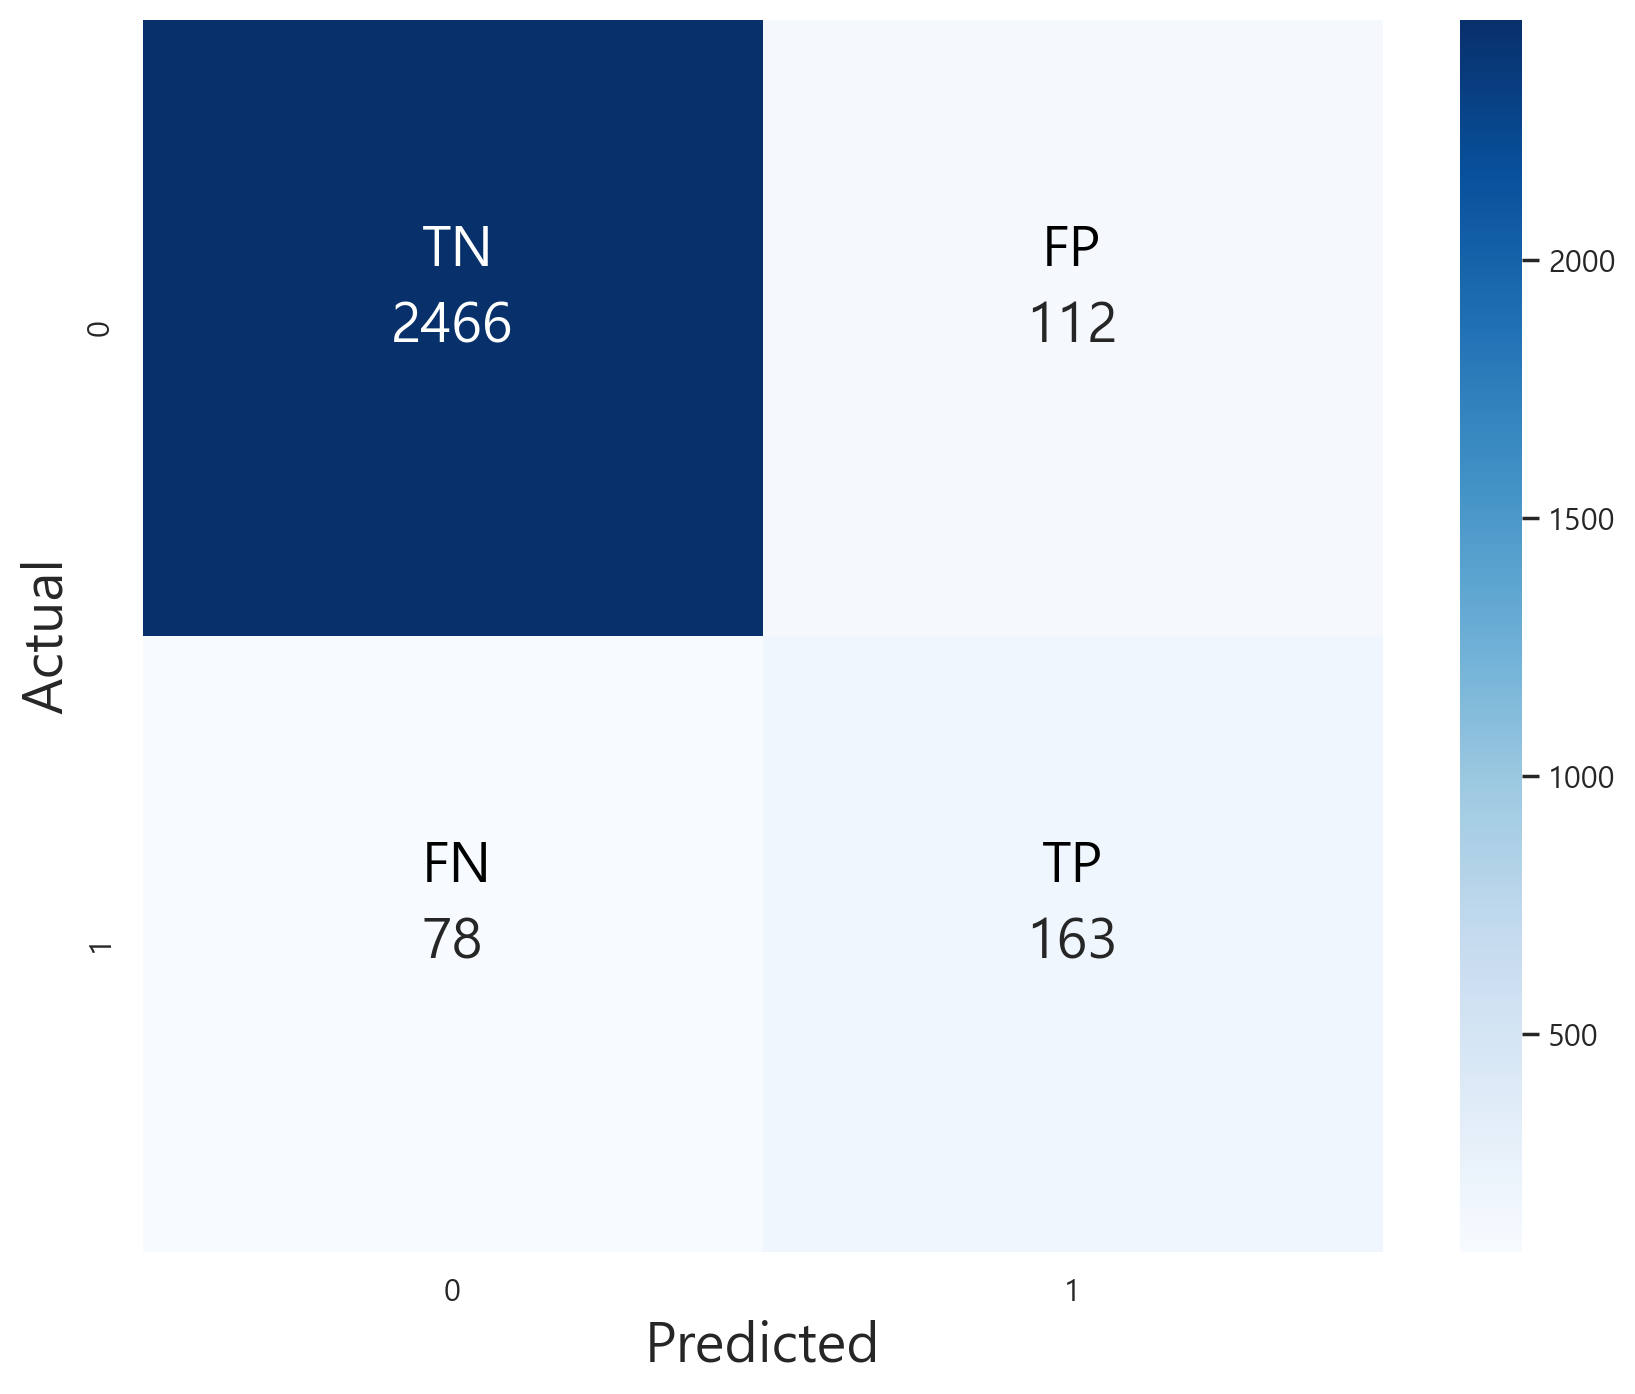

In [28]:
# 혼돈 행렬 시각화
cm = confusion_matrix(y_test, Y_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot = True, annot_kws = {'size':20}, fmt = '0.0f', cmap='Blues')
plt.xlabel('Predicted', size = 20)
plt.ylabel('Actual', size = 20)
plt.text(0.45, 0.4, 'TN', color = 'w', fontsize = 20)
plt.text(1.45, 0.4, 'FP', color = 'black', fontsize = 20)
plt.text(0.45, 1.4, 'FN', color = 'black', fontsize = 20)
plt.text(1.45, 1.4, 'TP', color = 'black', fontsize = 20)
plt.show()

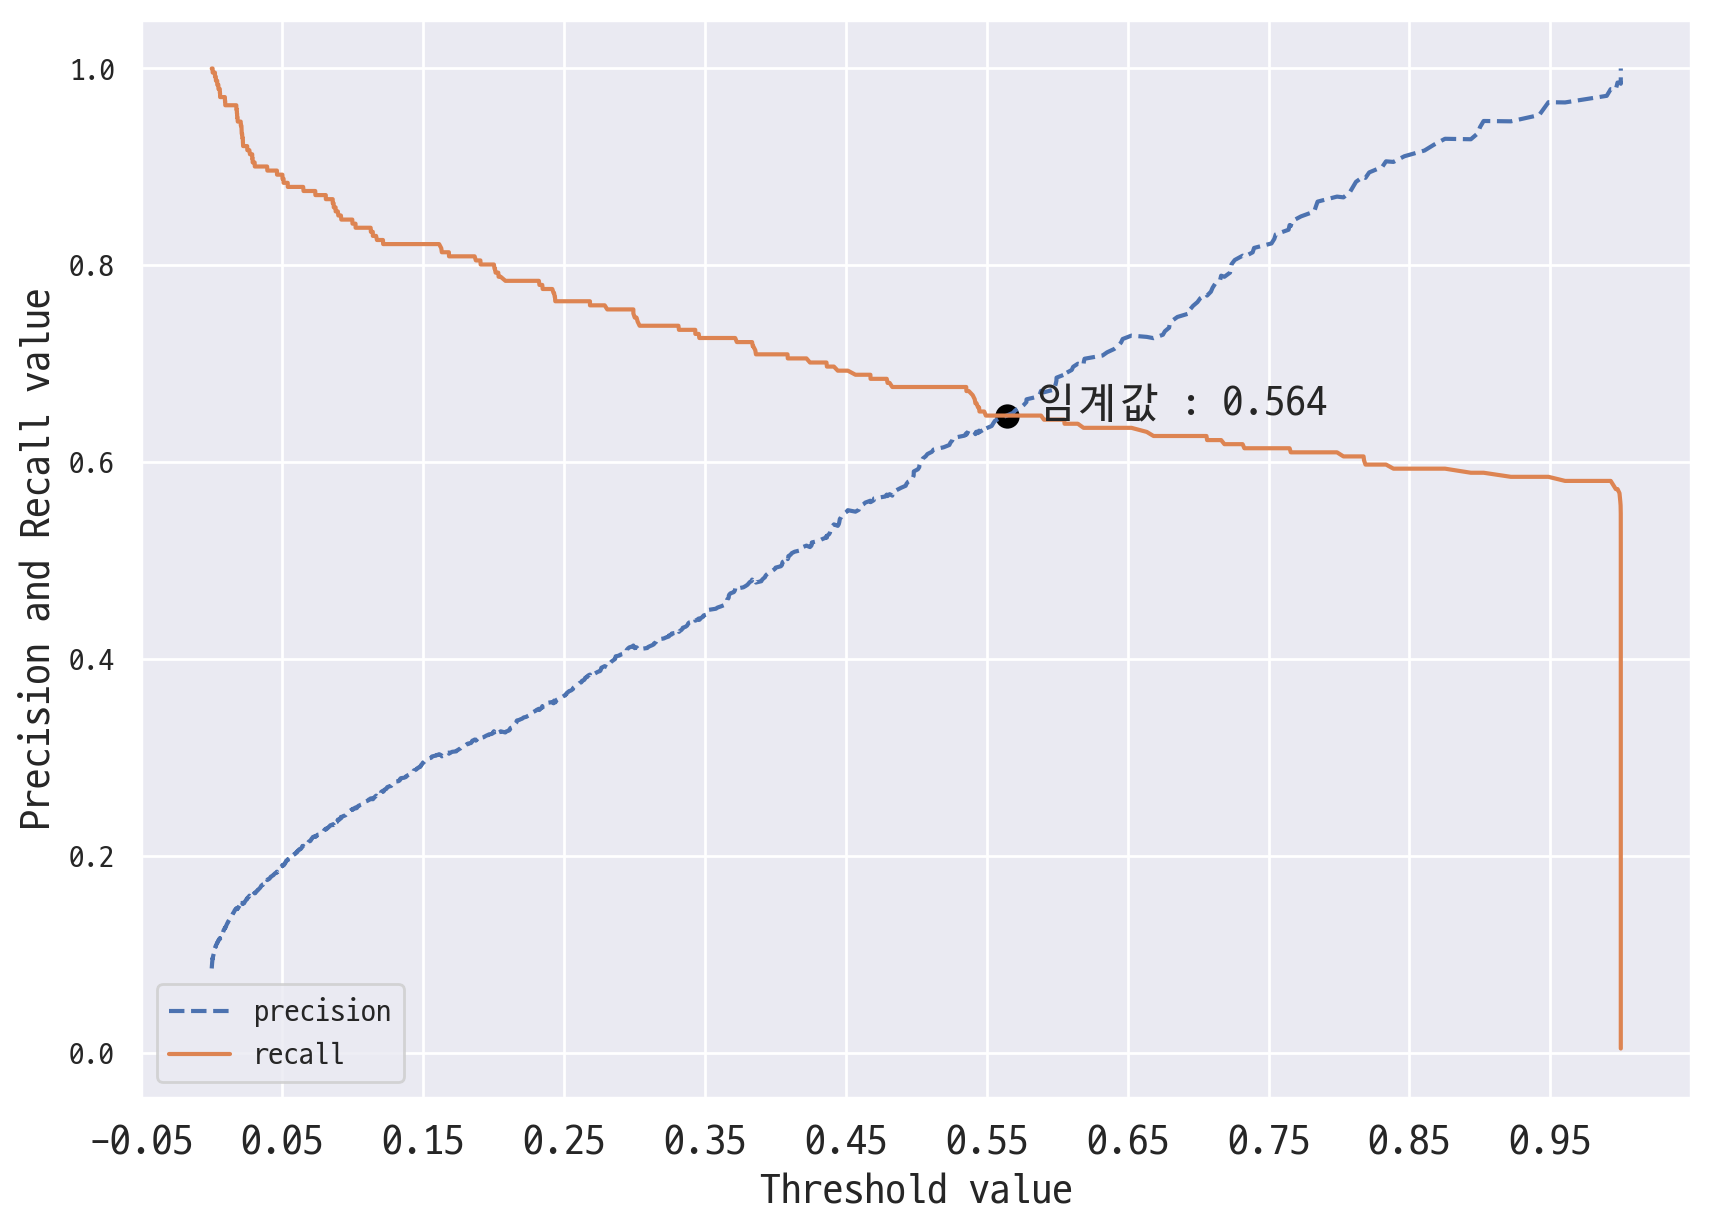

In [29]:
precision_recall_curve_plot(y_test, Y_pred_proba)

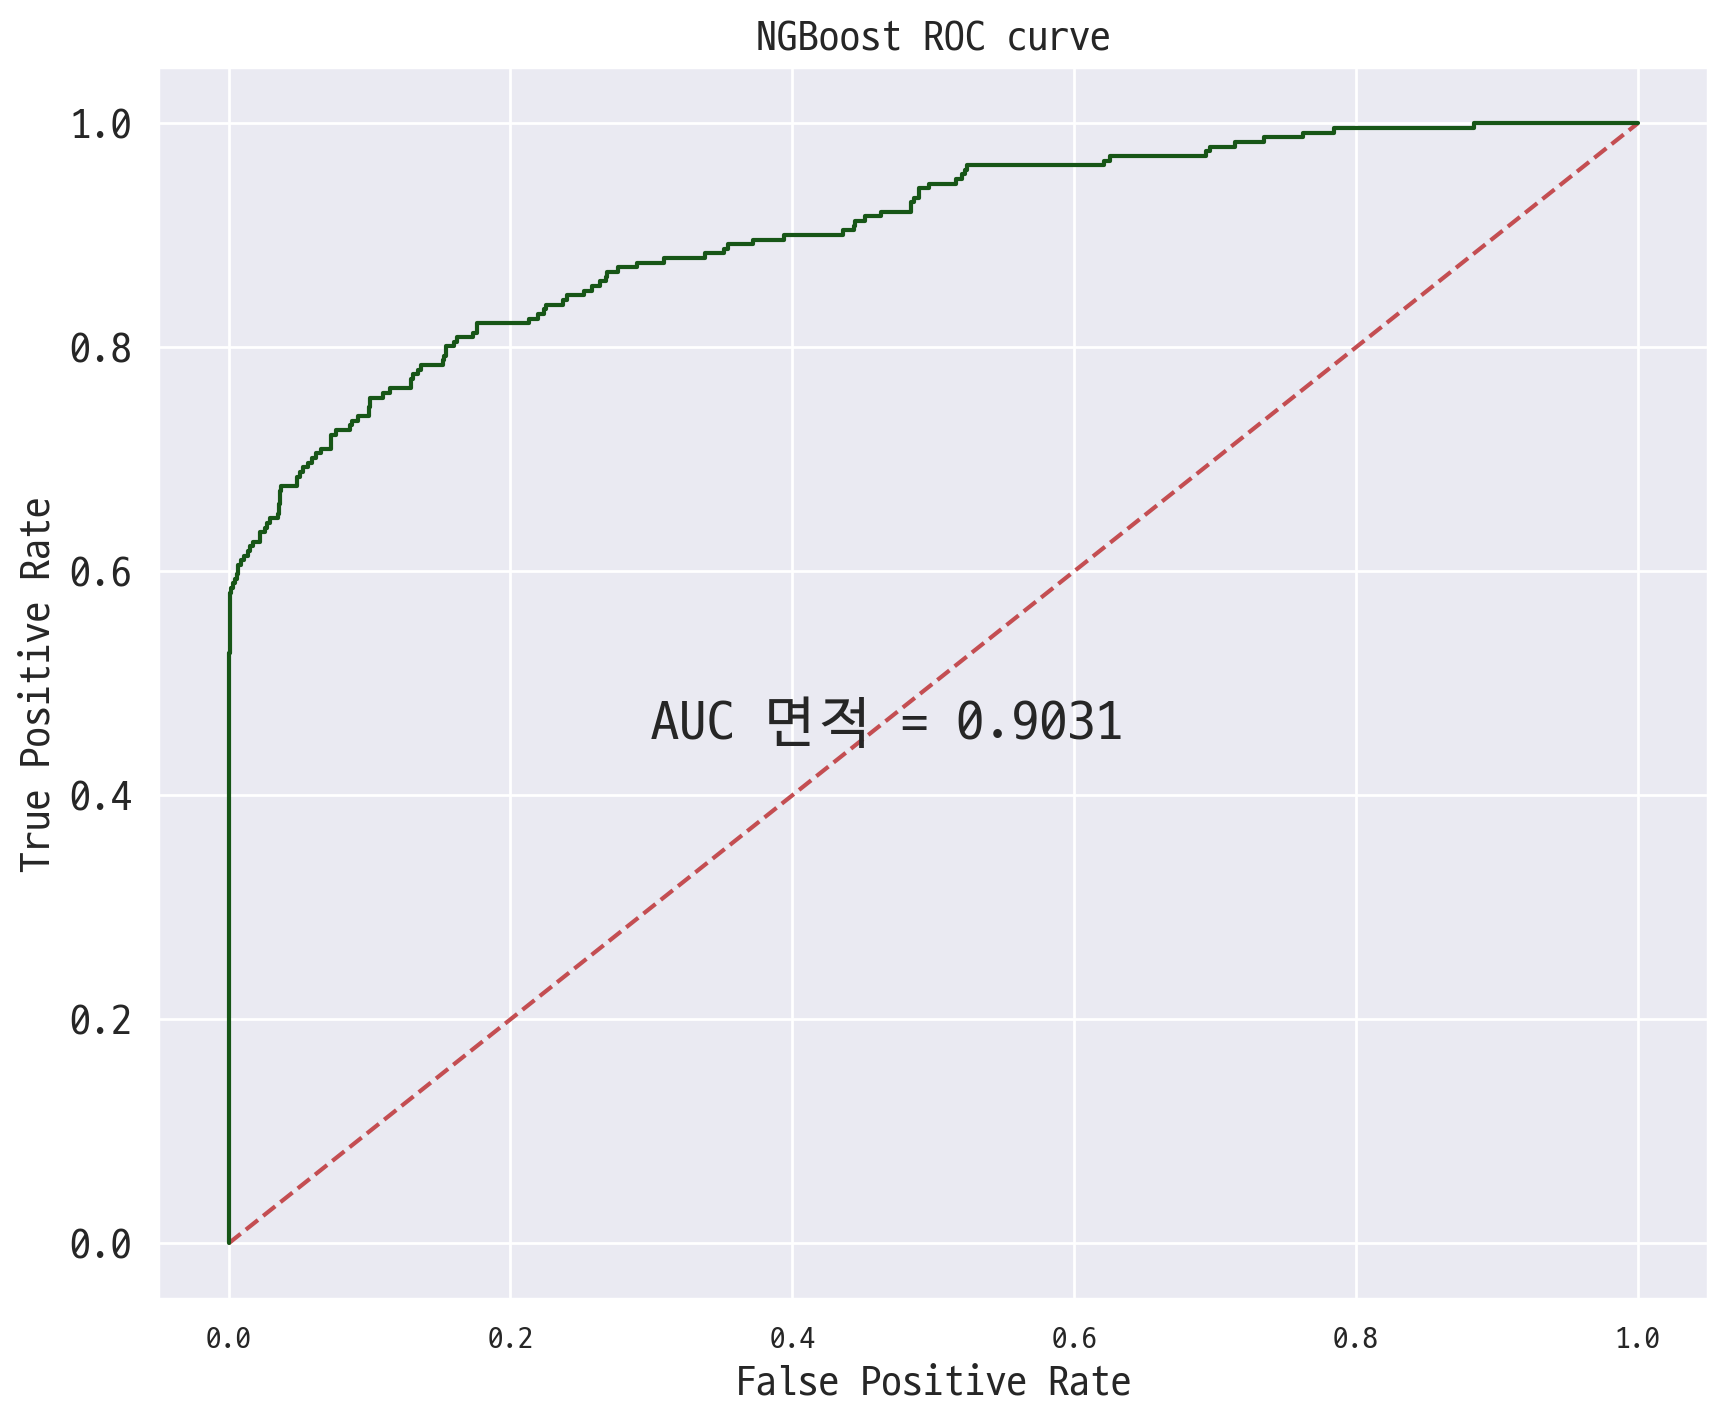

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, Y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot([0,1], [0,1], "r--")
plt.plot(fpr, tpr, label='NGBoost', color = '#175617')
plt.xlabel('False Positive Rate', size = 15)
plt.ylabel('True Positive Rate', size = 15)
plt.title('NGBoost ROC curve', size = 15)
plt.text(0.3, 0.45, 'AUC 면적 = {}'.format(round(roc_auc_score(y_test, Y_pred_proba), 4)), size = 20)
plt.show()

## 오버샘플링 & hyperOpt & NGBoost

In [31]:
ngb = NGBClassifier(random_state = 42, Dist=k_categorical(2), n_estimators = 500, verbose = 1, learning_rate = 0.05,
                   minibatch_frac=0.4, col_sample=0.8)

ngb.fit(X_train_over, y_train_over, early_stopping_rounds = 300)


Y_preds = ngb.predict(X_test)
Y_pred_proba = ngb.predict_proba(X_test)[:, 1]

[iter 0] loss=0.6931 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2088 val_loss=0.0000 scale=4.0000 norm=5.6443
[iter 200] loss=0.1856 val_loss=0.0000 scale=1.0000 norm=1.4563
[iter 300] loss=0.1673 val_loss=0.0000 scale=0.5000 norm=0.7346
[iter 400] loss=0.1497 val_loss=0.0000 scale=1.0000 norm=1.3754


In [32]:
get_clf_eval(y_test, Y_preds, Y_pred_proba)
print('Macro f1 socre : ', f1_score(y_test, Y_preds, average='macro'))

오차 행렬
[[2452  126]
 [  75  166]]
정확도 : 0.9287, 정밀도 : 0.5685, 재현율 : 0.6888, F1 : 0.6229, AUC : 0.9018
Macro f1 socre :  0.7917580711255015


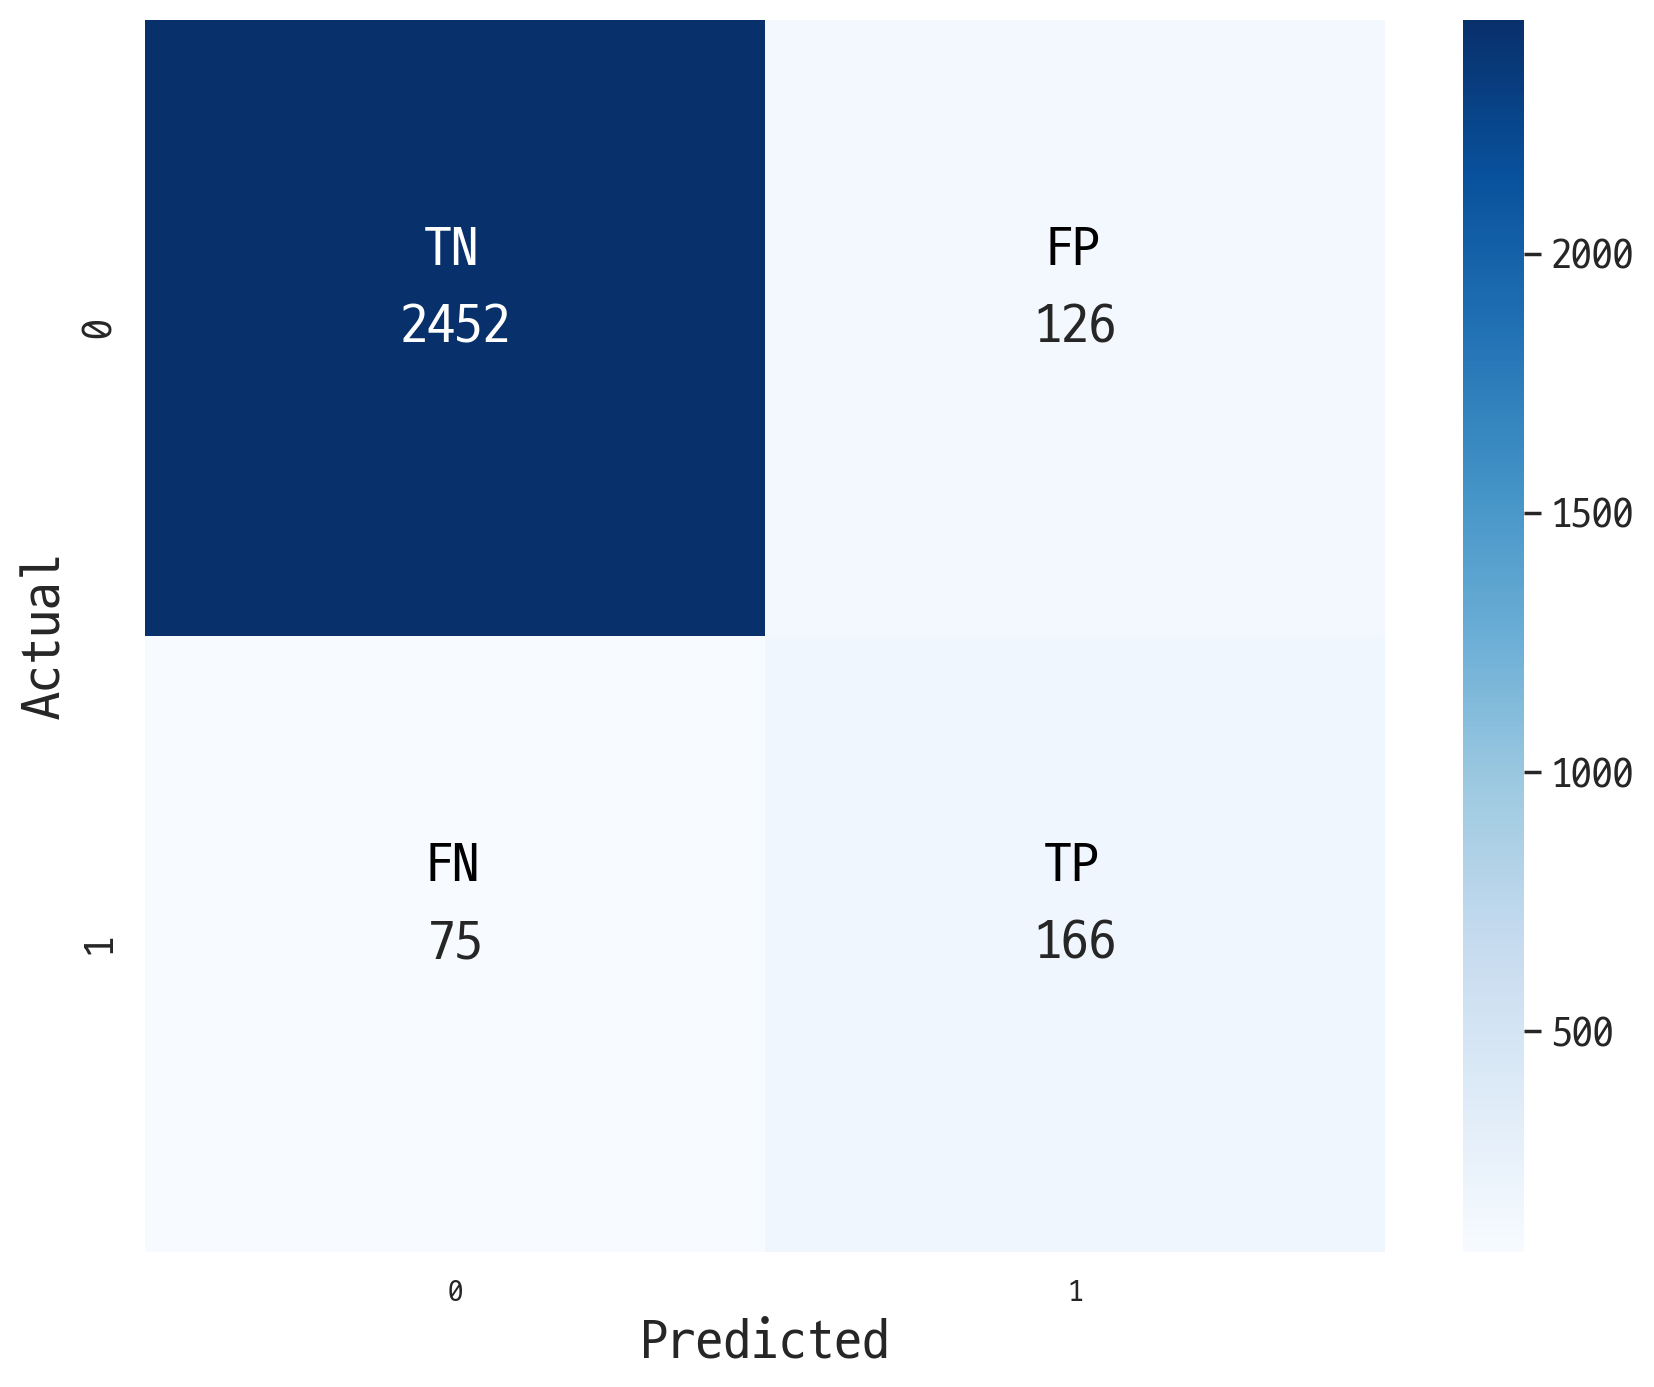

In [33]:
# 혼돈 행렬 시각화
cm = confusion_matrix(y_test, Y_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot = True, annot_kws = {'size':20}, fmt = '0.0f', cmap='Blues')
plt.xlabel('Predicted', size = 20)
plt.ylabel('Actual', size = 20)
plt.text(0.45, 0.4, 'TN', color = 'w', fontsize = 20)
plt.text(1.45, 0.4, 'FP', color = 'black', fontsize = 20)
plt.text(0.45, 1.4, 'FN', color = 'black', fontsize = 20)
plt.text(1.45, 1.4, 'TP', color = 'black', fontsize = 20)
plt.show()

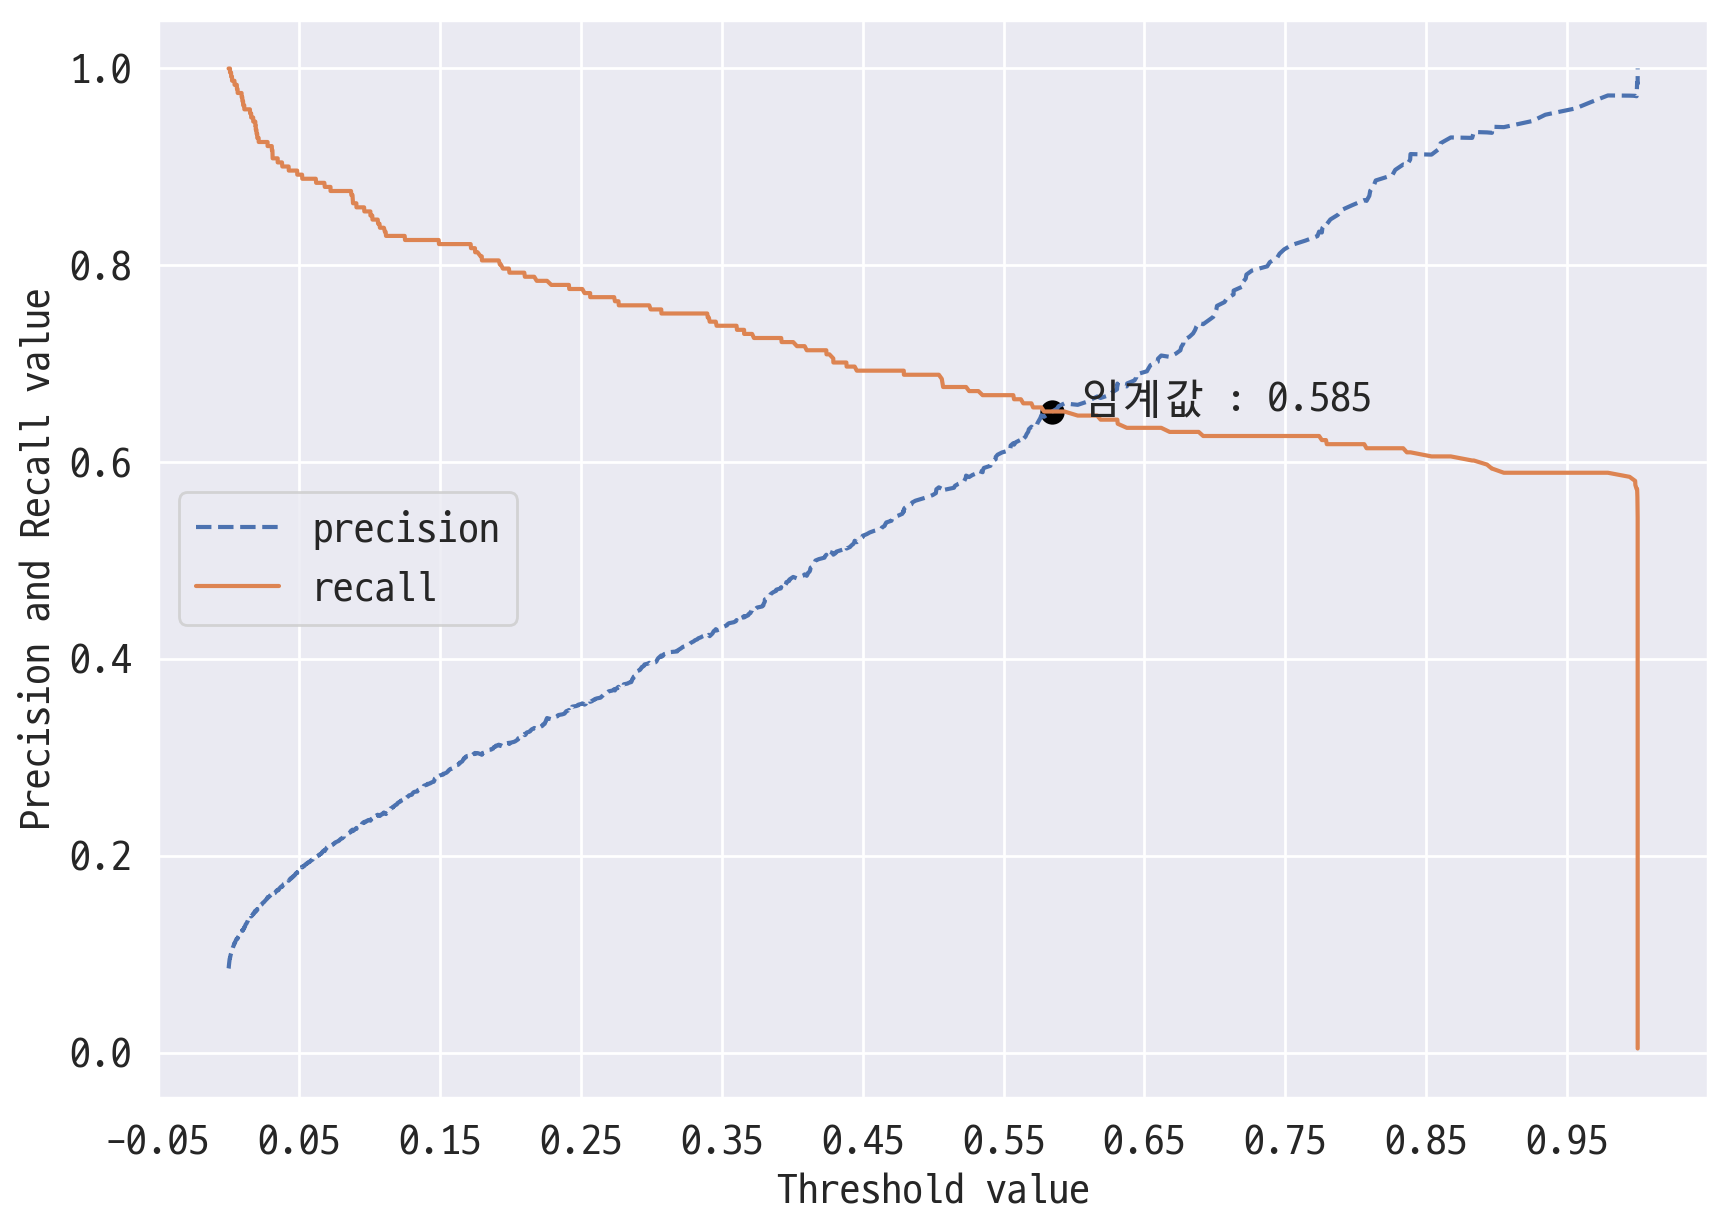

In [34]:
precision_recall_curve_plot(y_test, Y_pred_proba)

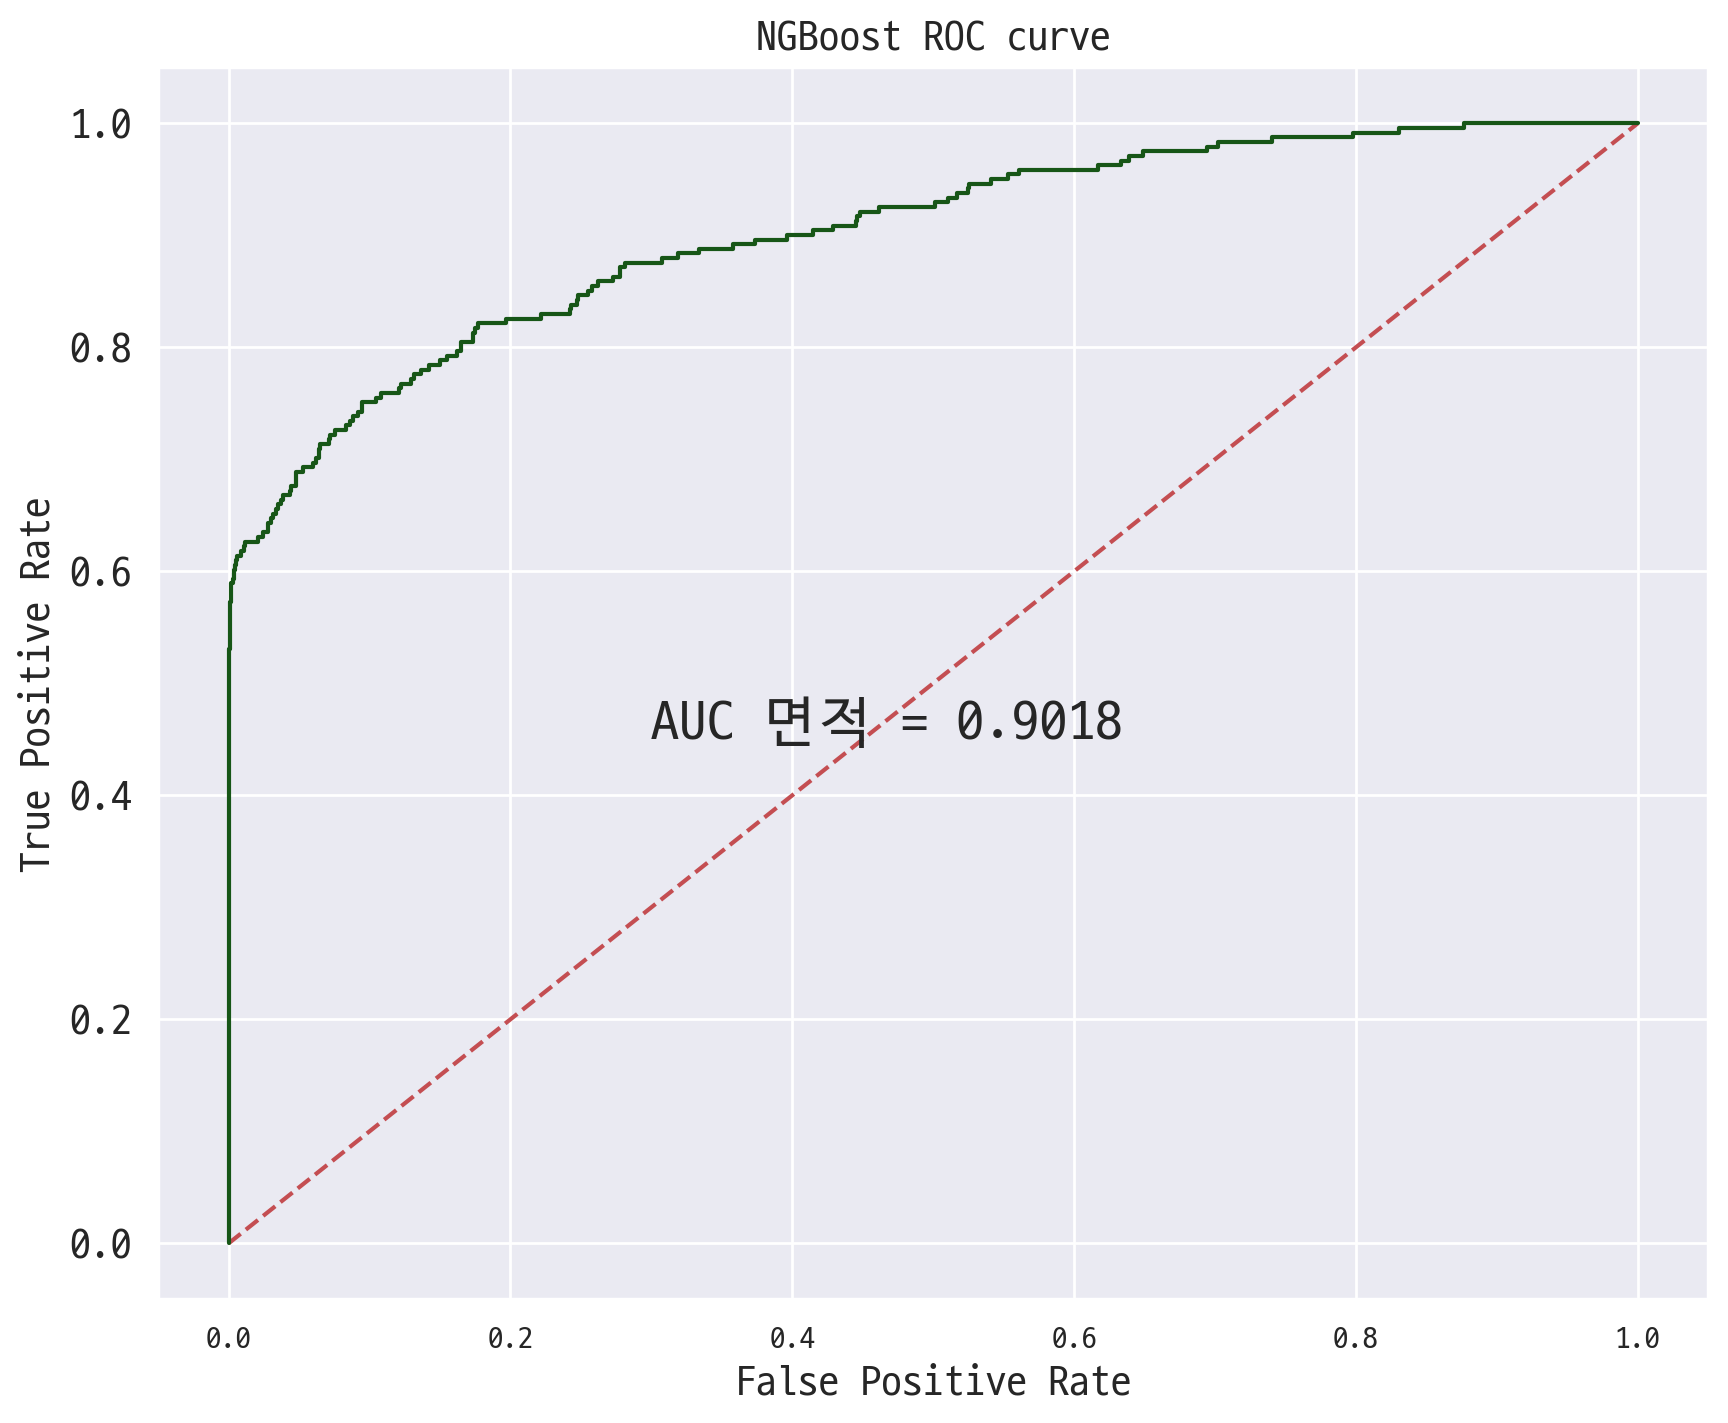

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, Y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot([0,1], [0,1], "r--")
plt.plot(fpr, tpr, label='NGBoost', color = '#175617')
plt.xlabel('False Positive Rate', size = 15)
plt.ylabel('True Positive Rate', size = 15)
plt.title('NGBoost ROC curve', size = 15)
plt.text(0.3, 0.45, 'AUC 면적 = {}'.format(round(roc_auc_score(y_test, Y_pred_proba), 4)), size = 20)
plt.show()

## 오버 & 언더 샘플링 & hyperOpt & NGBoost 

In [36]:
ngb = NGBClassifier(random_state = 42, Dist=k_categorical(2), n_estimators = 500, verbose = 1, learning_rate = 0.05,
                   minibatch_frac=0.4, col_sample=0.8)
ngb.fit(X_train_smt, y_train_smt, early_stopping_rounds = 300)


Y_preds = ngb.predict(X_test)
Y_pred_proba = ngb.predict_proba(X_test)[:, 1]

[iter 0] loss=0.6931 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2085 val_loss=0.0000 scale=2.0000 norm=2.8110
[iter 200] loss=0.1772 val_loss=0.0000 scale=0.5000 norm=0.7019
[iter 300] loss=0.1711 val_loss=0.0000 scale=0.2500 norm=0.3685
[iter 400] loss=0.1539 val_loss=0.0000 scale=0.5000 norm=0.6899


In [37]:
get_clf_eval(y_test, Y_preds, Y_pred_proba)
print('Macro f1 socre : ', f1_score(y_test, Y_preds, average='macro'))

오차 행렬
[[2461  117]
 [  77  164]]
정확도 : 0.9312, 정밀도 : 0.5836, 재현율 : 0.6805, F1 : 0.6284, AUC : 0.9003
Macro f1 socre :  0.7952161201129953


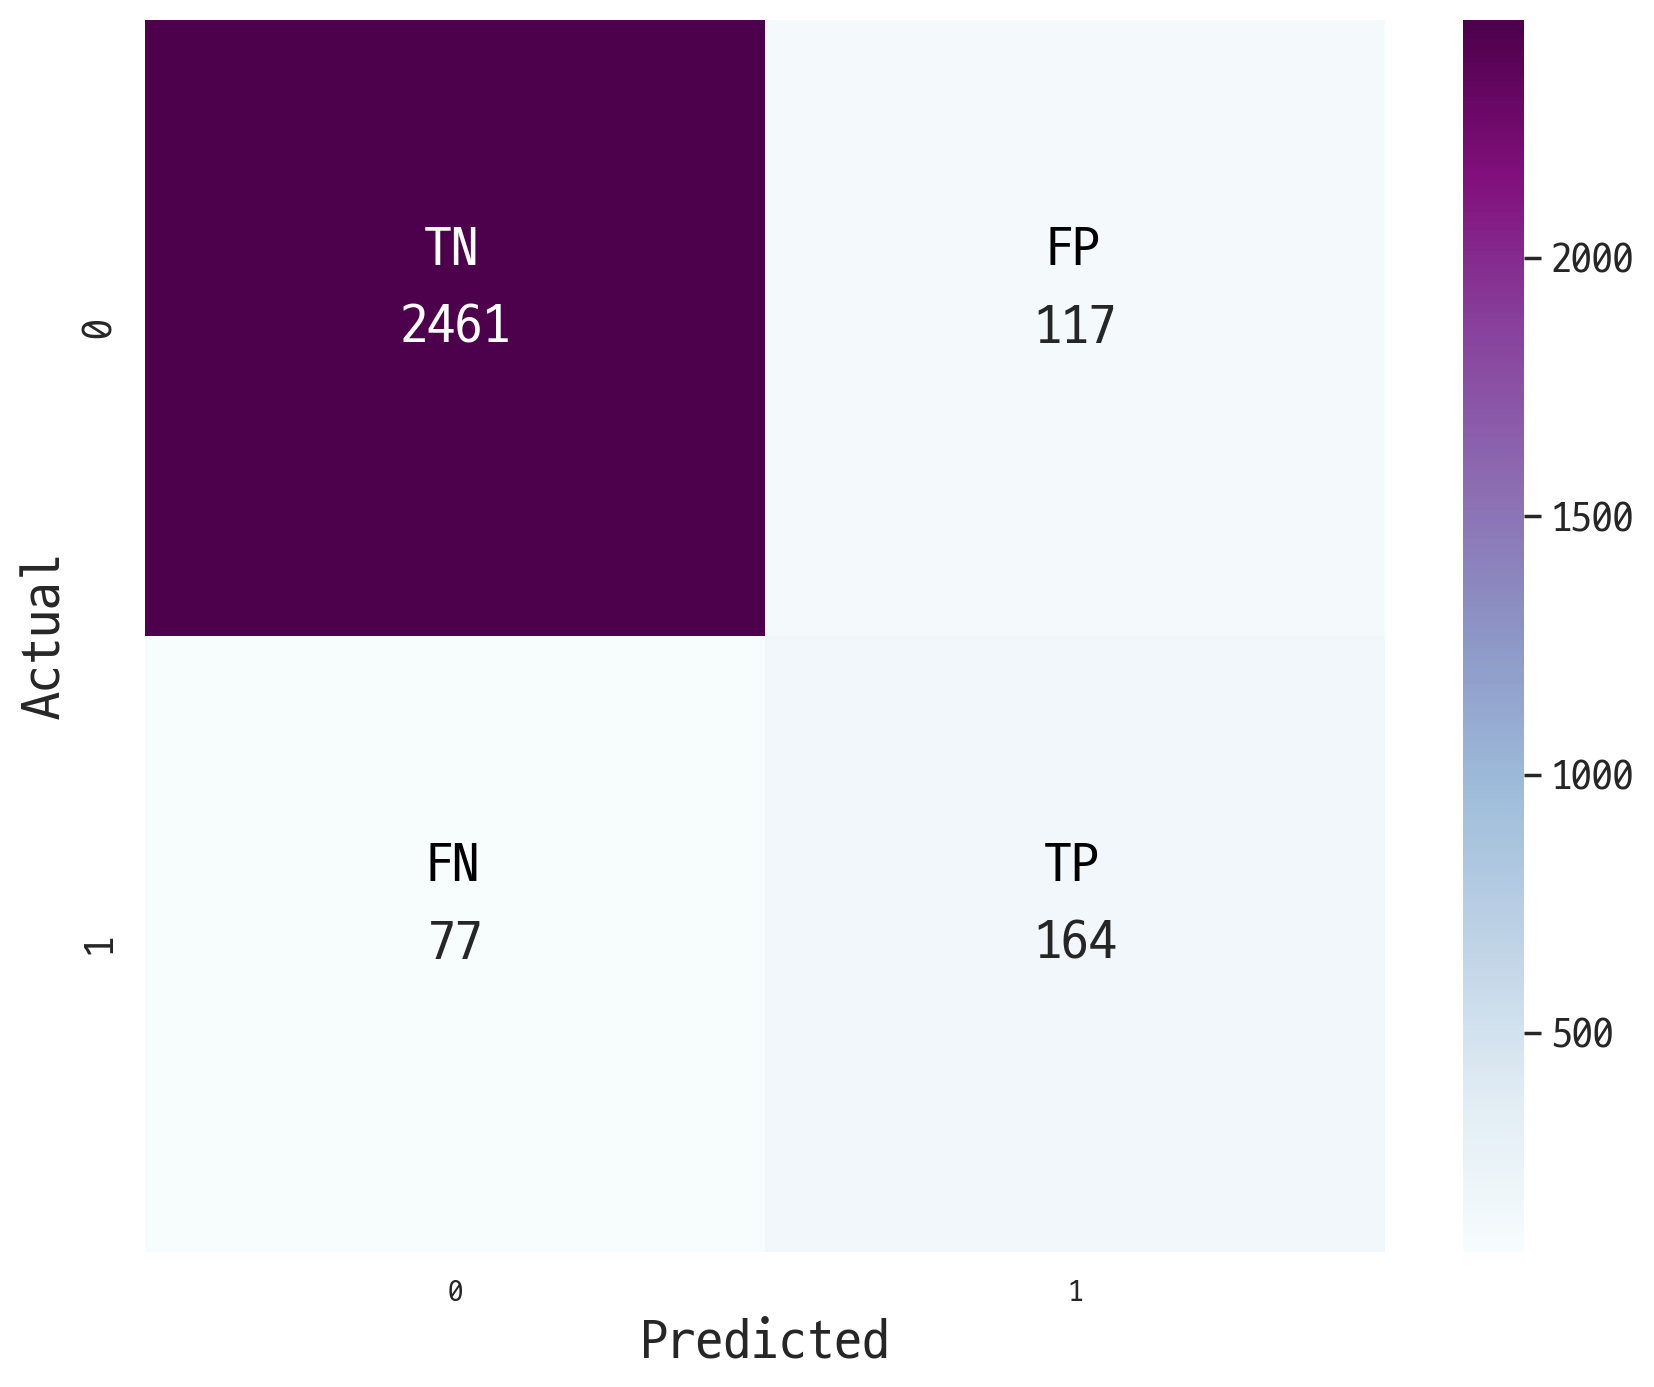

In [50]:
# 혼돈 행렬 시각화
cm = confusion_matrix(y_test, Y_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot = True, annot_kws = {'size':20}, fmt = '0.0f', cmap='BuPu')
plt.xlabel('Predicted', size = 20)
plt.ylabel('Actual', size = 20)
plt.text(0.45, 0.4, 'TN', color = 'w', fontsize = 20)
plt.text(1.45, 0.4, 'FP', color = 'black', fontsize = 20)
plt.text(0.45, 1.4, 'FN', color = 'black', fontsize = 20)
plt.text(1.45, 1.4, 'TP', color = 'black', fontsize = 20)
plt.show()

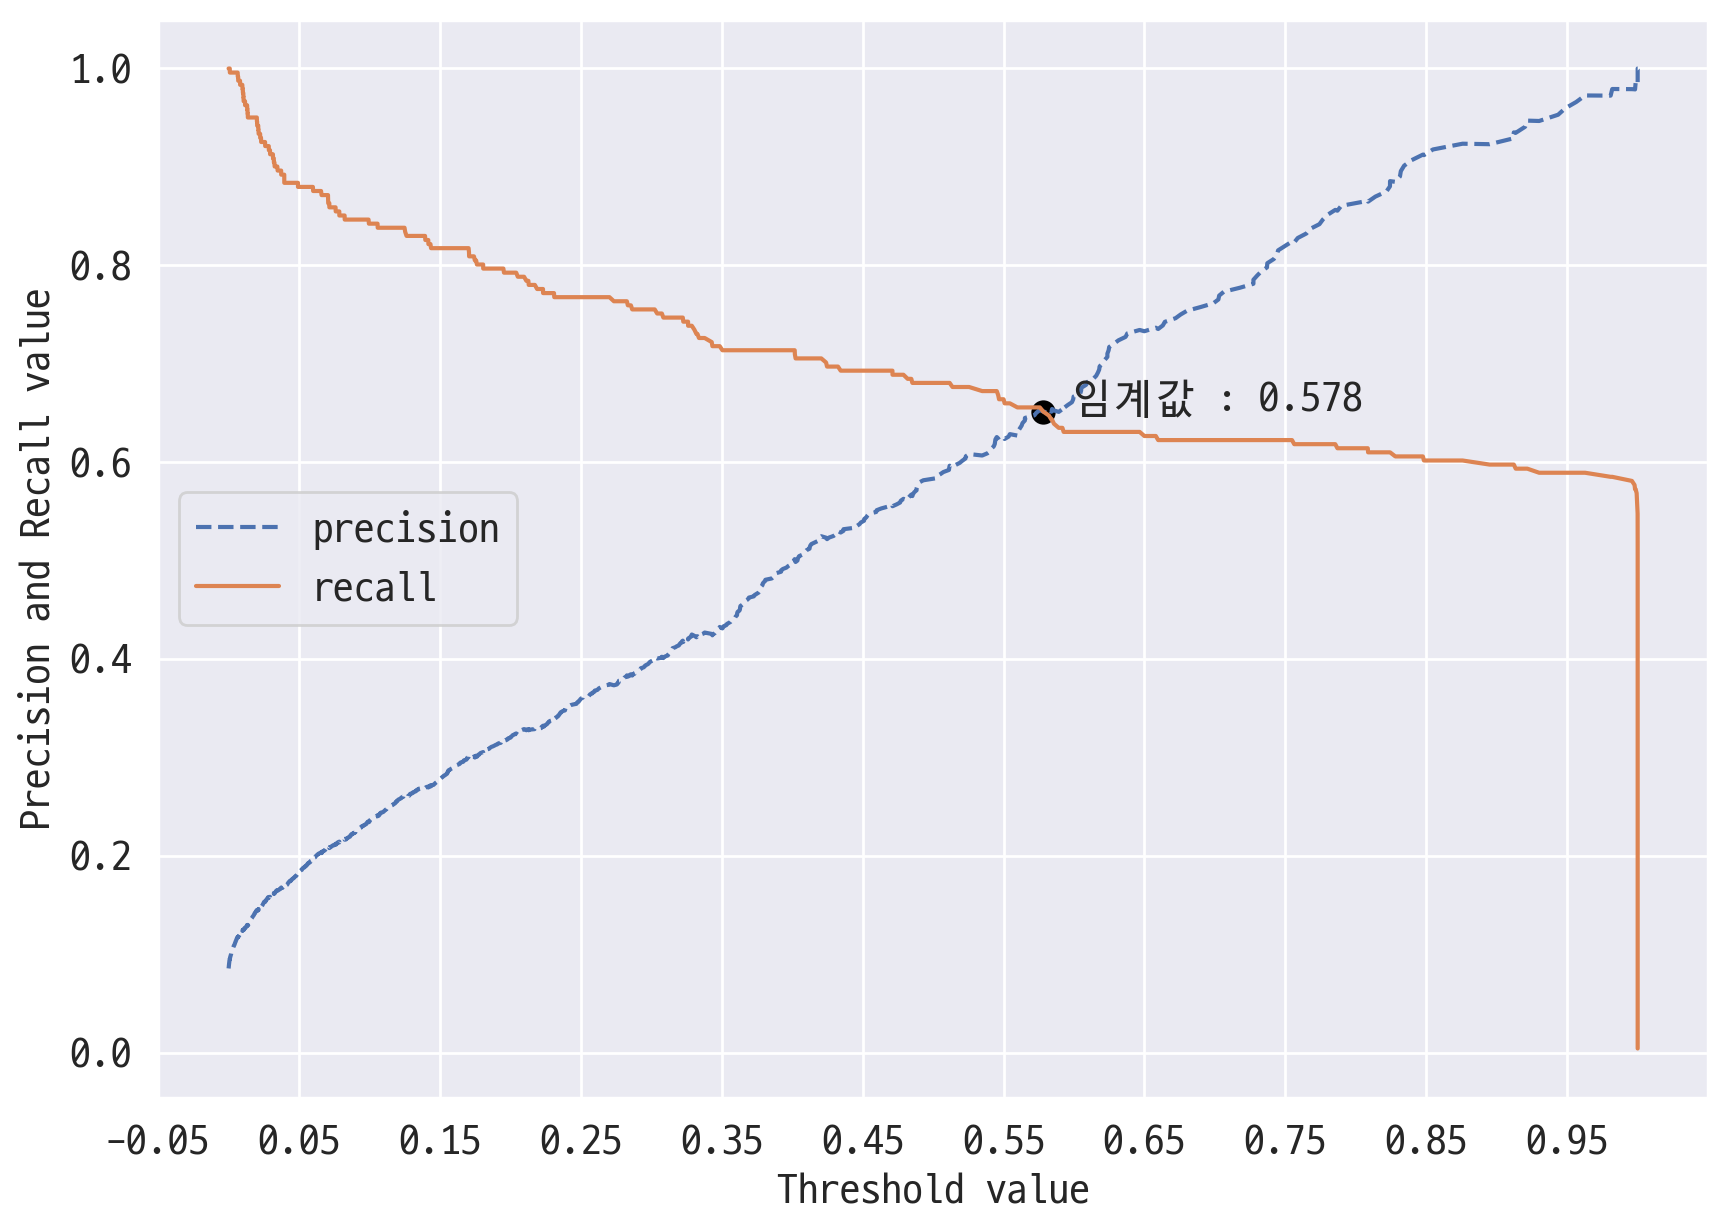

In [39]:
precision_recall_curve_plot(y_test, Y_pred_proba)

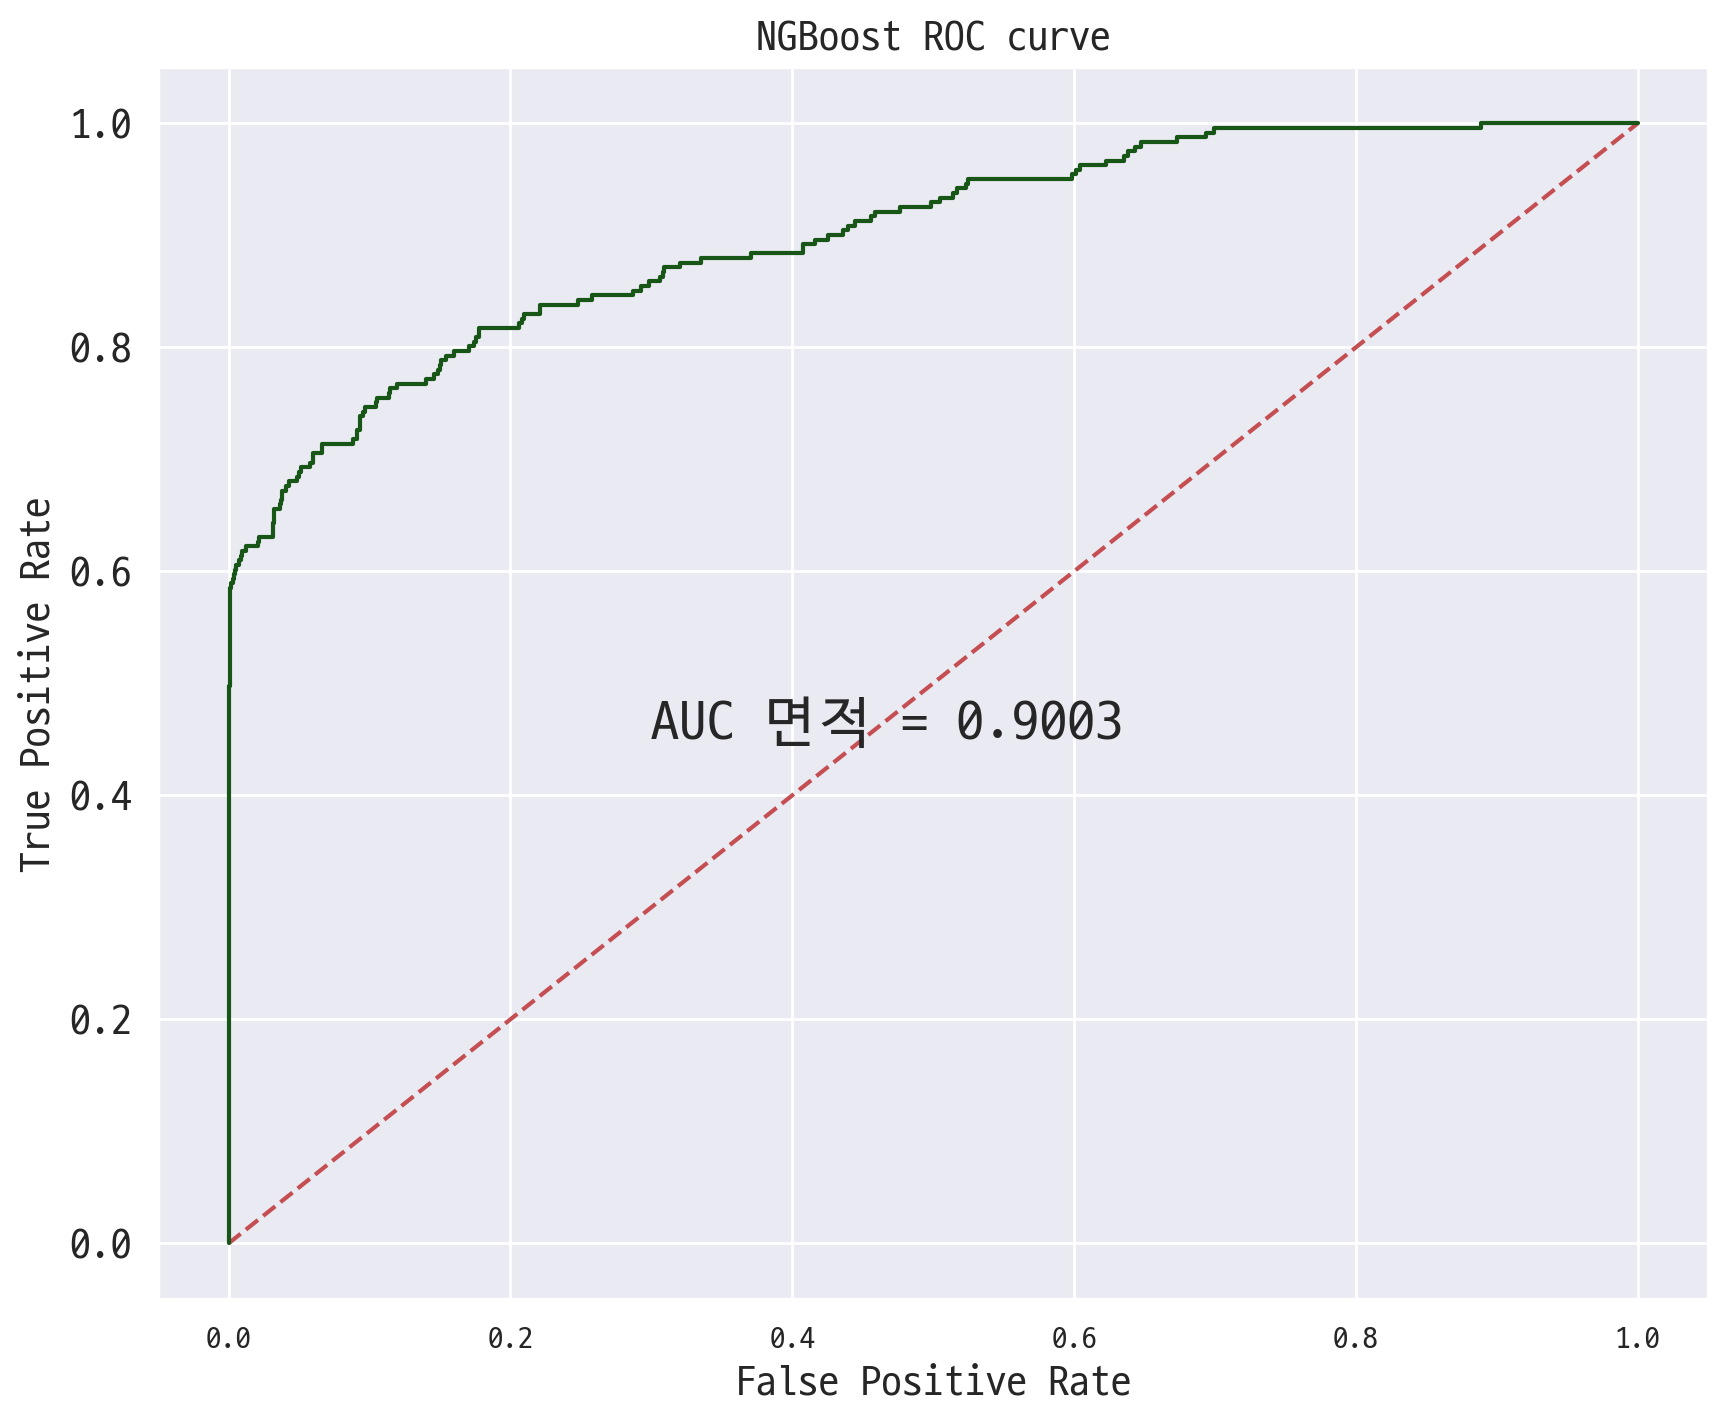

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, Y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot([0,1], [0,1], "r--")
plt.plot(fpr, tpr, label='NGBoost', color = '#175617')
plt.xlabel('False Positive Rate', size = 15)
plt.ylabel('True Positive Rate', size = 15)
plt.title('NGBoost ROC curve', size = 15)
plt.text(0.3, 0.45, 'AUC 면적 = {}'.format(round(roc_auc_score(y_test, Y_pred_proba), 4)), size = 20)
plt.show()

In [47]:
binarizer = Binarizer(threshold = 0.381)
thres_pred = binarizer.fit_transform(Y_pred_proba.reshape(-1,1))

get_clf_eval(y_test, thres_pred, Y_pred_proba.reshape(-1,1))
print('Macro f1 socre : ', f1_score(y_test, thres_pred, average='macro'))

오차 행렬
[[2393  185]
 [  69  172]]
정확도 : 0.9099, 정밀도 : 0.4818, 재현율 : 0.7137, F1 : 0.5753, AUC : 0.9003
Macro f1 socre :  0.7624270053617881


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

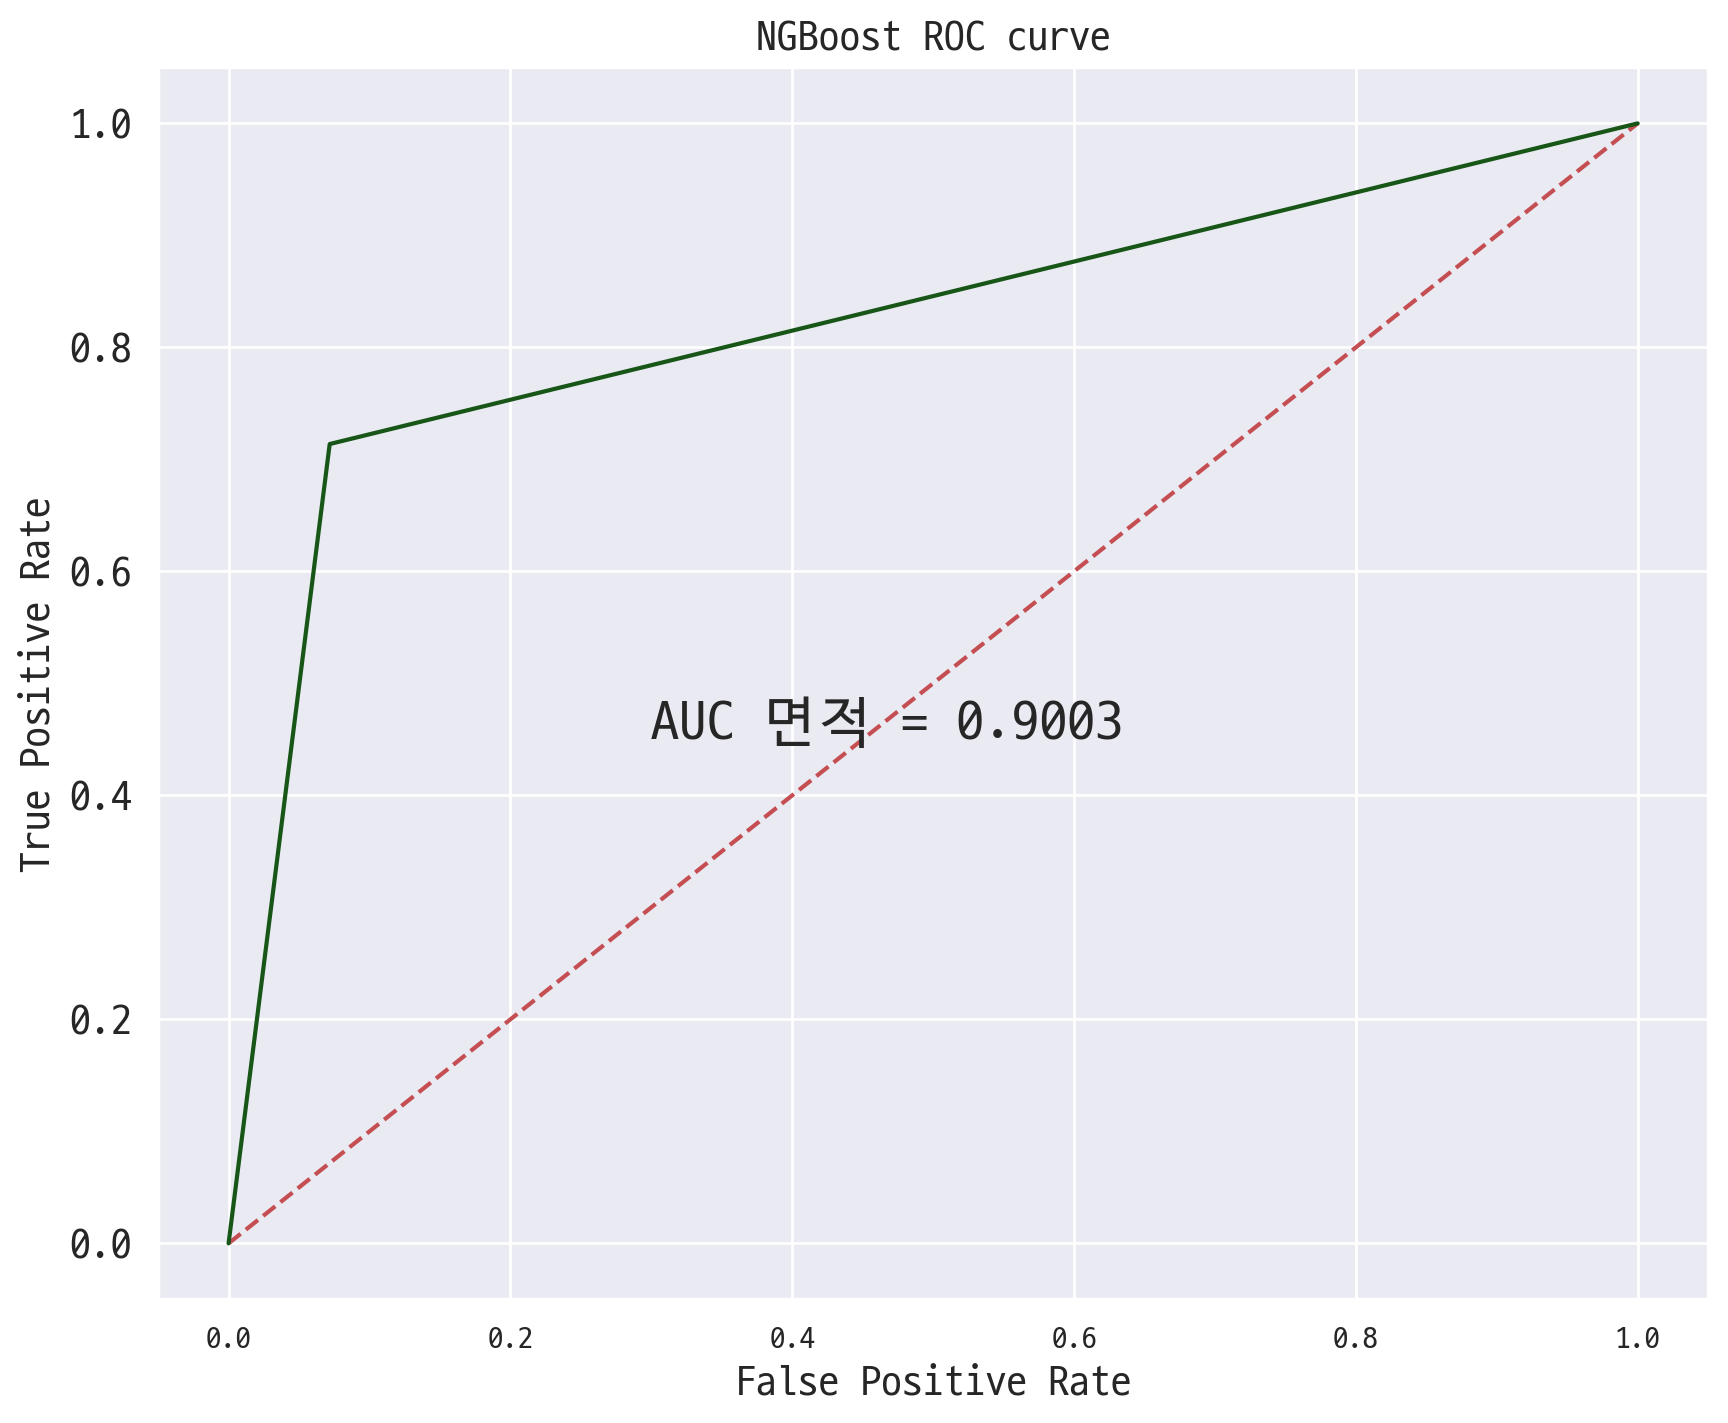

In [59]:
fpr, tpr, thresholds = roc_curve(y_test, thres_pred)

plt.figure(figsize=(10, 8))
plt.plot([0,1], [0,1], "r--")
plt.plot(fpr, tpr, label='NGBoost', color = '#175617')
plt.xlabel('False Positive Rate', size = 15)
plt.ylabel('True Positive Rate', size = 15)
plt.title('NGBoost ROC curve', size = 15)
plt.text(0.3, 0.45, 'AUC 면적 = {}'.format(round(roc_auc_score(y_test, Y_pred_proba), 4)), size = 20)
plt.show()

# 스태킹 앙상블

## 원본데이터

In [63]:
import numpy as np
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# 개별 ML 모델을 위한 Classifier 생성.
xgb = XGBClassifier(learning_rate =  0.07, max_depth = 157, subsample = 0.73)
                   


lgbm = LGBMClassifier(learning_rate = 0.038, max_depth = 132, 
                      min_child_samples = 97, num_leaves = 36, subsample = 0.94)

ngb = NGBClassifier(random_state = 42, n_estimators = 300, verbose = 0, learning_rate = 0.03)



# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = XGBClassifier(learning_rate =  0.07, max_depth = 157, subsample = 0.73)

# 개별 모델들을 학습. 
xgb.fit(X_train, y_train)
lgbm.fit(X_train , y_train)
ngb.fit(X_train , y_train)

# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
xgb_pred = xgb.predict(X_test)
lgbm_pred = lgbm.predict(X_test)
ngb_pred = ngb.predict(X_test)

print('XGB 정확도: {0:.4f}'.format(accuracy_score(y_test, xgb_pred)))
print('LGBM 정확도: {0:.4f}'.format(accuracy_score(y_test, lgbm_pred)))
print('NGBoost 정확도: {0:.4f}'.format(accuracy_score(y_test, ngb_pred)))
print('XGB macro f1 score : ', f1_score(y_test, xgb_pred, average = 'macro'))
print('LGBM  macro f1 score : ', f1_score(y_test, lgbm_pred, average = 'macro'))
print('NGBoost macro f1 score : ', f1_score(y_test, ngb_pred, average = 'macro'))

XGB 정확도: 0.9638
LGBM 정확도: 0.9620
NGBoost 정확도: 0.9631
XGB macro f1 score :  0.8627634593356243
LGBM  macro f1 score :  0.8529750528495884
NGBoost macro f1 score :  0.8553839839942543


In [ ]:
pred = np.array([xgb_pred, lgbm_pred, ngb_pred])

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)

lr_final.fit(pred, y_test)
final = lr_final.predict(pred)
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import re

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state = 2022)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))

    for folder_counter , (train_index, valid_index) in enumerate(skf.split(X_train_n, y_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드세트 :', folder_counter, ' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
   
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

X_train_n = X_train.reset_index(drop=True).values
X_test_n = X_test.reset_index(drop=True).values
y_train_n = y_train.reset_index(drop=True).values

xgb_train, xgb_test = get_stacking_base_datasets(xgb, X_train_n, y_train_n, X_test_n, 7)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm, X_train_n, y_train_n, X_test_n, 7)
ngb_train, ngb_test = get_stacking_base_datasets(ngb, X_train_n, y_train_n, X_test_n,  7)   

Stack_final_X_train = np.concatenate((xgb_train, lgbm_train, ngb_train), axis=1)
Stack_final_X_test = np.concatenate((xgb_test, lgbm_test, ngb_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

In [ ]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))
print('최종 메타 모델의 macro f1 score :', f1_score(y_test, stack_final, average = 'macro'))

In [ ]:
stack_final_proba = lr_final.predict_proba(Stack_final_X_test)[:, 1]
get_clf_eval(y_test, stack_final, stack_final_proba)

## 오버샘플링

In [64]:
# 개별 ML 모델을 위한 Classifier 생성.
xgb = XGBClassifier(learning_rate =  0.07, max_depth = 157, subsample = 0.73)
                   


lgbm = LGBMClassifier(learning_rate = 0.038, max_depth = 132, 
                      min_child_samples = 97, num_leaves = 36, subsample = 0.94)

ngb = NGBClassifier(random_state = 42, Dist=k_categorical(2), n_estimators = 500, verbose = 1, learning_rate = 0.05,
                   minibatch_frac=0.4, col_sample=0.8)



# 최종 Stacking 모델을 위한 Classifier생성. 
xgb_final = XGBClassifier(learning_rate =  0.07, max_depth = 157, subsample = 0.73)

# 개별 모델들을 학습. 
xgb.fit(X_train_over, y_train_over)
lgbm.fit(X_train_over , y_train_over)
ngb.fit(X_train_over , y_train_over)

# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
xgb_pred = xgb.predict(X_test)
lgbm_pred = lgbm.predict(X_test)
ngb_pred = ngb.predict(X_test)

print('XGB 정확도: {0:.4f}'.format(accuracy_score(y_test, xgb_pred)))
print('LGBM 정확도: {0:.4f}'.format(accuracy_score(y_test, lgbm_pred)))
print('NGBoost 정확도: {0:.4f}'.format(accuracy_score(y_test, ngb_pred)))
print('XGB macro f1 score : ', f1_score(y_test, xgb_pred, average = 'macro'))
print('LGBM  macro f1 score : ', f1_score(y_test, lgbm_pred, average = 'macro'))
print('NGBoost macro f1 score : ', f1_score(y_test, ngb_pred, average = 'macro'))

[iter 0] loss=0.6931 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2090 val_loss=0.0000 scale=2.0000 norm=2.8209
[iter 200] loss=0.1836 val_loss=0.0000 scale=0.5000 norm=0.7251
[iter 300] loss=0.1673 val_loss=0.0000 scale=1.0000 norm=1.4644
[iter 400] loss=0.1494 val_loss=0.0000 scale=1.0000 norm=1.3557
XGB 정확도: 0.9610
LGBM 정확도: 0.9599
NGBoost 정확도: 0.9322
XGB macro f1 score :  0.857884654164146
LGBM  macro f1 score :  0.8536867116151936
NGBoost macro f1 score :  0.7966317627911317


In [65]:
pred = np.array([xgb_pred, lgbm_pred, ngb_pred])

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)

xgb_final.fit(pred, y_test)
final = xgb_final.predict(pred)
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

최종 메타 모델의 예측 정확도: 0.9624


In [66]:
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state = 2022)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))

    for folder_counter , (train_index, valid_index) in enumerate(skf.split(X_train_n, y_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드세트 :', folder_counter, ' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
   
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

X_train_n = X_train_over.reset_index(drop=True).values
X_test_n = X_test.reset_index(drop=True).values
y_train_n = y_train_over.reset_index(drop=True).values

xgb_train, xgb_test = get_stacking_base_datasets(xgb, X_train_n, y_train_n, X_test_n, 7)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm, X_train_n, y_train_n, X_test_n, 7)
ngb_train, ngb_test = get_stacking_base_datasets(ngb, X_train_n, y_train_n, X_test_n,  7)   

Stack_final_X_train = np.concatenate((xgb_train, lgbm_train, ngb_train), axis=1)
Stack_final_X_test = np.concatenate((xgb_test, lgbm_test, ngb_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

	 폴드세트 : 0  시작 
	 폴드세트 : 1  시작 
	 폴드세트 : 2  시작 
	 폴드세트 : 3  시작 
	 폴드세트 : 4  시작 
	 폴드세트 : 5  시작 
	 폴드세트 : 6  시작 
	 폴드세트 : 0  시작 
	 폴드세트 : 1  시작 
	 폴드세트 : 2  시작 
	 폴드세트 : 3  시작 
	 폴드세트 : 4  시작 
	 폴드세트 : 5  시작 
	 폴드세트 : 6  시작 
	 폴드세트 : 0  시작 
[iter 0] loss=0.1446 val_loss=0.0000 scale=0.5000 norm=0.6827
[iter 100] loss=0.1352 val_loss=0.0000 scale=0.0001 norm=0.0002
[iter 200] loss=0.1426 val_loss=0.0000 scale=0.0001 norm=0.0002
[iter 300] loss=0.1273 val_loss=0.0000 scale=0.0001 norm=0.0002
[iter 400] loss=0.1333 val_loss=0.0000 scale=0.2500 norm=0.3538
	 폴드세트 : 1  시작 
[iter 0] loss=0.1324 val_loss=0.0000 scale=0.0312 norm=0.2159


LinAlgError: Singular matrix

In [ ]:
xgb_final = XGBClassifier(learning_rate =  0.07, max_depth = 157, subsample = 0.73)
xgb_final.fit(Stack_final_X_train, y_train_over)
stack_final = xgb_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))
print('최종 메타 모델의 macro f1 score :', f1_score(y_test, stack_final, average = 'macro'))

In [ ]:
stack_final_proba = xgb_final.predict_proba(Stack_final_X_test)[:, 1]
get_clf_eval(y_test, stack_final, stack_final_proba)

In [ ]:
#feature 중요도도 그려볼 수 있다. 
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 15))

# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_final, ax=ax)
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize = 30)
plt.show()

In [ ]:

Running(xgb_final, y_test, stack_final, stack_final_proba)